In [1]:
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import roc_curve, auc
from mlxtend.plotting import plot_learning_curves
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.inspection import permutation_importance
import time


# General function to open the file 
input only the file_paath

In [2]:

def open_file(file_path):
    """
    General function to open a file and return its DataFrame.
    The function relays on pandas
    Parameters:
    file_path (str): The path to the file.

    Returns:
    pd.DataFrame: DataFrame containing the file's data.
    """
    try:
        # Use default separator '\t' for tab-separated files
        df = pd.read_csv(file_path, sep='\t')
        print(f"Successfully loaded file: {file_path}")
        return df
    except Exception as e:
        print(f"Error loading file: {file_path}. Error: {e}")
        return None

# Example usage
file_path1 = "/home/user/Desktop/2024_08_27/master-project2/all_feature_labels.txt"
df1 = open_file(file_path1)


Successfully loaded file: /home/user/Desktop/2024_08_27/master-project2/all_feature_labels.txt


In [3]:
df1

,Class_label_sum,cell_line,condition,Gene_combination,single_gene_highist_avg_lfc,single_gene_lowest_avg_lfc,expected_combinatorial_lfc,combinatorial_avg_lfc,Euclidean_distance_expexted_observed,Euclidean_distance_singel_phenotype,...,pscore,ascore,escore,dscore,Jaccard Index_commun_proteins,Number of Common Proteins,Class_label_exp,Class_label_dep,Class_label_corr,Class_label_neg
0,no GI,A375,2CP,AAK1_BMP2K,-0.524813,-0.986385,-1.511197,-1.323147,0.188050,0.461572,...,0.000,0.000,0.0,0.00,0.333333,5,no GI,no GI,no GI,no GI
1,lol,A375,2CP,AARS1_AARS2,-2.982134,-4.557785,-7.539920,-4.733963,2.805956,1.575651,...,0.000,0.000,0.0,0.00,0.111111,2,no GI,no GI,no GI,Mixed
2,no GI,A375,2CP,ABCA2_ABCA3,-0.005448,-0.717969,-0.723418,0.234114,0.957531,0.712521,...,0.000,0.000,0.0,0.00,0.000000,0,no GI,no GI,no GI,no GI
3,no GI,A375,2CP,ABCA2_ABCA7,0.141434,-0.005448,0.135985,-0.228554,0.364539,0.146882,...,0.000,0.000,0.0,0.00,0.000000,0,no GI,no GI,no GI,no GI
4,no GI,A375,2CP,ABCA3_ABCA7,0.141434,-0.717969,-0.576535,-0.540774,0.035761,0.859403,...,0.000,0.000,0.0,0.00,0.000000,0,no GI,no GI,no GI,no GI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8714,no GI,Meljuso,2CP sel,ZSCAN30_ZSCAN31,0.242981,0.182299,0.425280,0.661490,0.236209,0.060682,...,0.000,0.000,0.0,0.00,0.000000,0,no GI,no GI,no GI,no GI
8715,no GI,Meljuso,2CP sel,ZSCAN30_ZSCAN9,0.642505,0.242981,0.885486,0.273976,0.611510,0.399523,...,0.000,0.000,0.0,0.00,0.066667,1,no GI,no GI,no GI,no GI
8716,no GI,Meljuso,2CP sel,ZSCAN31_ZSCAN9,0.642505,0.182299,0.824804,0.432295,0.392508,0.460205,...,0.000,0.000,0.0,0.00,0.125000,1,no GI,no GI,no GI,no GI
8717,no GI,Meljuso,2CP sel,ZSWIM4_ZSWIM6,0.165044,-0.601162,-0.436118,-0.324097,0.112021,0.766206,...,0.057,0.053,0.0,0.54,0.666667,8,no GI,no GI,no GI,no GI


# Function to filter raws only want to use in spicific classafier

In [4]:

def filter_rows(df, column_name_no_GI, no_GI_value, column_name_GI, GI_value):
    """
    Filters rows in the DataFrame based on two column conditions (either condition can be true).
    
    Parameters:
    df (pd.DataFrame): The DataFrame to filter.
    column_name_no_GI (str): The name of the first column to filter on (e.g., 'Class_label_neg').
    no_GI_value: The value to filter for in the first column (e.g., 'no GI').
    column_name_GI (str): The name of the second column to filter on (e.g., 'Class_label_sum').
    GI_value: The value to filter for in the second column (e.g., 'GI').

    Returns:
    pd.DataFrame: A DataFrame containing rows that match either of the conditions.
    """
    try:
        # Apply filtering conditions with OR (`|`)
        filtered_df = df[(df[column_name_no_GI] == no_GI_value) | (df[column_name_GI] == GI_value)]
        print(f"Filtered DataFrame has {filtered_df.shape[0]} rows and {filtered_df.shape[1]} columns.")
        return filtered_df
    except KeyError as e:
        print(f"Column not found: {e}")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

# Filter rows where "Class_label_neg" is "no GI" and "Class_label_sum" is "GI"
filtered_df = filter_rows(df1, "Class_label_neg", "no GI", "Class_label_corr", "GI")

# Display filtered DataFrame
print(filtered_df)

Filtered DataFrame has 6154 rows and 40 columns.
     Class_label_sum cell_line condition Gene_combination  \
0              no GI      A375       2CP       AAK1_BMP2K   
2              no GI      A375       2CP      ABCA2_ABCA3   
3              no GI      A375       2CP      ABCA2_ABCA7   
4              no GI      A375       2CP      ABCA3_ABCA7   
5              no GI      A375       2CP     ABCB10_ABCB8   
...              ...       ...       ...              ...   
8714           no GI   Meljuso   2CP sel  ZSCAN30_ZSCAN31   
8715           no GI   Meljuso   2CP sel   ZSCAN30_ZSCAN9   
8716           no GI   Meljuso   2CP sel   ZSCAN31_ZSCAN9   
8717           no GI   Meljuso   2CP sel    ZSWIM4_ZSWIM6   
8718           no GI   Meljuso   2CP sel        ZXDB_ZXDC   

      single_gene_highist_avg_lfc  single_gene_lowest_avg_lfc  \
0                       -0.524813                   -0.986385   
2                       -0.005448                   -0.717969   
3                      

# Function to create a temporary label column based on the desired condition

/tmp/ipykernel_19900/3909819009.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temp_class_label'] = df.apply(


New column 'temp_class_label' has been added to the DataFrame.


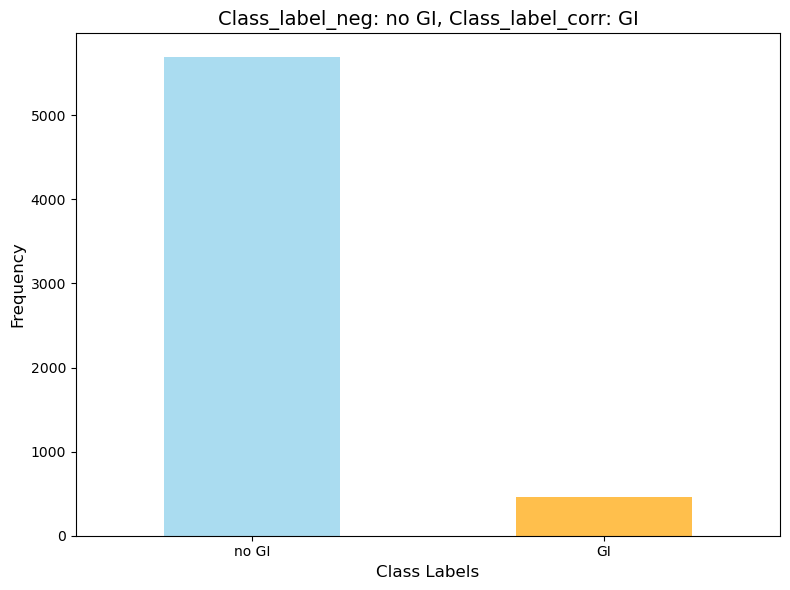

,Class_label_sum,cell_line,condition,Gene_combination,single_gene_highist_avg_lfc,single_gene_lowest_avg_lfc,expected_combinatorial_lfc,combinatorial_avg_lfc,Euclidean_distance_expexted_observed,Euclidean_distance_singel_phenotype,...,ascore,escore,dscore,Jaccard Index_commun_proteins,Number of Common Proteins,Class_label_exp,Class_label_dep,Class_label_corr,Class_label_neg,temp_class_label
0,no GI,A375,2CP,AAK1_BMP2K,-0.524813,-0.986385,-1.511197,-1.323147,0.188050,0.461572,...,0.000,0.0,0.00,0.333333,5,no GI,no GI,no GI,no GI,no GI
2,no GI,A375,2CP,ABCA2_ABCA3,-0.005448,-0.717969,-0.723418,0.234114,0.957531,0.712521,...,0.000,0.0,0.00,0.000000,0,no GI,no GI,no GI,no GI,no GI
3,no GI,A375,2CP,ABCA2_ABCA7,0.141434,-0.005448,0.135985,-0.228554,0.364539,0.146882,...,0.000,0.0,0.00,0.000000,0,no GI,no GI,no GI,no GI,no GI
4,no GI,A375,2CP,ABCA3_ABCA7,0.141434,-0.717969,-0.576535,-0.540774,0.035761,0.859403,...,0.000,0.0,0.00,0.000000,0,no GI,no GI,no GI,no GI,no GI
5,no GI,A375,2CP,ABCB10_ABCB8,0.480443,-2.020990,-1.540546,-0.952027,0.588519,2.501433,...,0.000,0.0,0.00,0.111111,2,no GI,no GI,no GI,no GI,no GI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8714,no GI,Meljuso,2CP sel,ZSCAN30_ZSCAN31,0.242981,0.182299,0.425280,0.661490,0.236209,0.060682,...,0.000,0.0,0.00,0.000000,0,no GI,no GI,no GI,no GI,no GI
8715,no GI,Meljuso,2CP sel,ZSCAN30_ZSCAN9,0.642505,0.242981,0.885486,0.273976,0.611510,0.399523,...,0.000,0.0,0.00,0.066667,1,no GI,no GI,no GI,no GI,no GI
8716,no GI,Meljuso,2CP sel,ZSCAN31_ZSCAN9,0.642505,0.182299,0.824804,0.432295,0.392508,0.460205,...,0.000,0.0,0.00,0.125000,1,no GI,no GI,no GI,no GI,no GI
8717,no GI,Meljuso,2CP sel,ZSWIM4_ZSWIM6,0.165044,-0.601162,-0.436118,-0.324097,0.112021,0.766206,...,0.053,0.0,0.54,0.666667,8,no GI,no GI,no GI,no GI,no GI


In [5]:

import pandas as pd
import matplotlib.pyplot as plt

def assign_and_visualize_class_label(df, column_name_no_GI, no_GI_value, column_name_GI, GI_value):
    """
    Adds a new column 'temp_class_label' based on two conditions and visualizes the class distribution.
    The function rely on pandas and matplotlib pyplot function
    Parameters:
    df (pd.DataFrame): The DataFrame to modify.
    column_name_no_GI (str): The first column to filter on (e.g., 'Class_label_neg').
    no_GI_value: The value to assign 'no GI' if it matches in the first column.
    column_name_GI (str): The second column to filter on (e.g., 'Class_label_sum').
    GI_value: The value to assign 'GI' if it matches in the second column.

    Returns:
    pd.DataFrame: The DataFrame with the new 'temp_class_label' column.
    """
    try:
        # Create the 'temp_class_label' column based on the conditions
        df['temp_class_label'] = df.apply(
            lambda row: 'GI' if row[column_name_GI] == GI_value else 
                        ('no GI' if row[column_name_no_GI] == no_GI_value else 'Excluded'),
            axis=1
        )

        print(f"New column 'temp_class_label' has been added to the DataFrame.")
        
        # Generate dynamic title based on input column names and values
        plot_title = f"{column_name_no_GI}: {no_GI_value}, {column_name_GI}: {GI_value}"

        # Visualize the distribution of 'temp_class_label' with a histogram
        plt.figure(figsize=(8, 6))
        df['temp_class_label'].value_counts().plot(kind='bar', color=['skyblue', 'orange'], alpha=0.7)
        
        # Set plot title and labels
        plt.title(plot_title, fontsize=14)
        plt.xlabel('Class Labels', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.xticks(rotation=0)
        plt.tight_layout()

        # Display the plot
        plt.show()

        return df

    except KeyError as e:
        print(f"Column not found: {e}")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None
    

 # Add the 'temp_class_label' based on conditions
df_label = assign_and_visualize_class_label(filtered_df, "Class_label_neg", "no GI", "Class_label_corr", "GI")
df_label

# Chech if there are missing values and replace them with 0

The function prints out the missing values before replacing them and returns the DataFrame with missing values replaced by 0.

In [6]:
def check_and_replace_missing_values(df):
    # Check if there are missing values in the DataFrame
    missing_values = df.isnull().sum()
    print("Missing values:")
    print(missing_values)
    
    # Replace missing values with 0
    df_filled = df.fillna(0)
    
    # Return the updated DataFrame
    return df_filled

# Call the function
filtered_df = check_and_replace_missing_values(filtered_df)
filtered_df

Missing values:
Class_label_sum                           0
cell_line                                 0
condition                                 0
Gene_combination                          0
single_gene_highist_avg_lfc               0
single_gene_lowest_avg_lfc                0
expected_combinatorial_lfc                0
combinatorial_avg_lfc                     0
Euclidean_distance_expexted_observed      0
Euclidean_distance_singel_phenotype       0
highist_expression                        0
lowest_expression                         0
Euclidean_distance_expresstion            0
expre_Correlation                         0
highist_dep                              23
lowest_dep                               23
Euclidean_distance_dep                  206
dep_Correlation                          18
highist_damage_mutation                 692
lowest_damage_mutation                  692
Euclidean_distance_dm                   692
Jaccard BP Similarity                     0
Jaccard MF Simil

,Class_label_sum,cell_line,condition,Gene_combination,single_gene_highist_avg_lfc,single_gene_lowest_avg_lfc,expected_combinatorial_lfc,combinatorial_avg_lfc,Euclidean_distance_expexted_observed,Euclidean_distance_singel_phenotype,...,ascore,escore,dscore,Jaccard Index_commun_proteins,Number of Common Proteins,Class_label_exp,Class_label_dep,Class_label_corr,Class_label_neg,temp_class_label
0,no GI,A375,2CP,AAK1_BMP2K,-0.524813,-0.986385,-1.511197,-1.323147,0.188050,0.461572,...,0.000,0.0,0.00,0.333333,5,no GI,no GI,no GI,no GI,no GI
2,no GI,A375,2CP,ABCA2_ABCA3,-0.005448,-0.717969,-0.723418,0.234114,0.957531,0.712521,...,0.000,0.0,0.00,0.000000,0,no GI,no GI,no GI,no GI,no GI
3,no GI,A375,2CP,ABCA2_ABCA7,0.141434,-0.005448,0.135985,-0.228554,0.364539,0.146882,...,0.000,0.0,0.00,0.000000,0,no GI,no GI,no GI,no GI,no GI
4,no GI,A375,2CP,ABCA3_ABCA7,0.141434,-0.717969,-0.576535,-0.540774,0.035761,0.859403,...,0.000,0.0,0.00,0.000000,0,no GI,no GI,no GI,no GI,no GI
5,no GI,A375,2CP,ABCB10_ABCB8,0.480443,-2.020990,-1.540546,-0.952027,0.588519,2.501433,...,0.000,0.0,0.00,0.111111,2,no GI,no GI,no GI,no GI,no GI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8714,no GI,Meljuso,2CP sel,ZSCAN30_ZSCAN31,0.242981,0.182299,0.425280,0.661490,0.236209,0.060682,...,0.000,0.0,0.00,0.000000,0,no GI,no GI,no GI,no GI,no GI
8715,no GI,Meljuso,2CP sel,ZSCAN30_ZSCAN9,0.642505,0.242981,0.885486,0.273976,0.611510,0.399523,...,0.000,0.0,0.00,0.066667,1,no GI,no GI,no GI,no GI,no GI
8716,no GI,Meljuso,2CP sel,ZSCAN31_ZSCAN9,0.642505,0.182299,0.824804,0.432295,0.392508,0.460205,...,0.000,0.0,0.00,0.125000,1,no GI,no GI,no GI,no GI,no GI
8717,no GI,Meljuso,2CP sel,ZSWIM4_ZSWIM6,0.165044,-0.601162,-0.436118,-0.324097,0.112021,0.766206,...,0.053,0.0,0.54,0.666667,8,no GI,no GI,no GI,no GI,no GI


In [7]:
# Get numeric columns (either int or float)
numeric_columns = filtered_df.select_dtypes(include=['number']).columns

# Display the numeric columns
print(f"Numeric columns: {numeric_columns}")

Numeric columns: Index(['single_gene_highist_avg_lfc', 'single_gene_lowest_avg_lfc',
       'expected_combinatorial_lfc', 'combinatorial_avg_lfc',
       'Euclidean_distance_expexted_observed',
       'Euclidean_distance_singel_phenotype', 'highist_expression',
       'lowest_expression', 'Euclidean_distance_expresstion',
       'expre_Correlation', 'highist_dep', 'lowest_dep',
       'Euclidean_distance_dep', 'dep_Correlation', 'highist_damage_mutation',
       'lowest_damage_mutation', 'Euclidean_distance_dm',
       'Jaccard BP Similarity', 'Jaccard MF Similarity',
       'Jaccard CC Similarity', 'Average Wang BP Similarity',
       'Average Wang MF Similarity', 'Average Wang CC Similarity', 'score',
       'nscore', 'fscore', 'pscore', 'ascore', 'escore', 'dscore',
       'Jaccard Index_commun_proteins', 'Number of Common Proteins'],
      dtype='object')


# General function to split the data in two set training and test set with ensuring the reprecentaion of both class label GI and no GI

The stratification ensures that the proportions of each class in temp_class_label are preserved in both the training and testing sets.
Map the label 'GI' to 1 and 'no GI' to 0 because LabelEncoder will assign values based on the default order, which may vary. The LabelEncoder helps convert categorical values to numeric values, which is important for machine learning models as they require numeric inputs

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd

def split_train_test_with_stratify(df, target_col, exclude_cols, test_size=0.2, random_state=0):
    """
    Splits the data into training and test sets with stratification to preserve class distribution.
     The function need train_test_split from sklearn.model_selection 
     LabelEncoder function from from sklearn.preprocessing 
     pandass
    Parameters:
        df (pd.DataFrame): The input DataFrame.
        target_col (str): The column name of the target variable (y).
        exclude_cols (list): List of column names to exclude from the features (X).
        test_size (float): Proportion of the dataset to be used as test (default: 0.2).
        random_state (int): Random state for reproducibility (default: 0).
        
    Returns:
        X_train, X_test: Feature sets for training and testing.
        y_train, y_test: Target sets for training and testing.
        label_encoder: The label encoder used for target encoding.
    """
    # Separate features and target
    X = df.drop(columns=exclude_cols)
    y = df[target_col]
    
    # Manually map 'GI' to 1 and 'no GI' to 0 using .map() 
    y = y.map({'GI': 1, 'no GI': 0})
    
    # Ensure type is explicitly int (important for machine learning models)
    y = y.astype(int)
    
    # Encode the target labels using LabelEncoder 
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    # Split data into training and test sets with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=test_size, random_state=random_state, stratify=y_encoded
    )
    
    # Print label distributions to confirm stratification
    print("Original label distribution:", pd.Series(y).value_counts().to_dict())
    print("Training label distribution:", pd.Series(y_train).value_counts().to_dict())
    print("Testing label distribution:", pd.Series(y_test).value_counts().to_dict())
    
    # Print encoded class mapping
    print("Encoded classes:", label_encoder.classes_)
    
    return X_train, X_test, y_train, y_test, label_encoder

# Call the function with your DataFrame
X_train, X_test, y_train, y_test, label_encoder = split_train_test_with_stratify(
    df=filtered_df,
    target_col='temp_class_label',
    exclude_cols=['Class_label_sum', 'cell_line', 'condition', 'Gene_combination', 'Class_label_exp','Class_label_dep','Class_label_corr','Class_label_neg','temp_class_label','expre_Correlation','highist_expression','lowest_expression','Euclidean_distance_expresstion'],
    test_size=0.2,
    random_state=0
)

# Get the column names of X_train
column_names = X_train.columns.tolist()
print(column_names)

Original label distribution: {0: 5690, 1: 464}
Training label distribution: {0: 4552, 1: 371}
Testing label distribution: {0: 1138, 1: 93}
Encoded classes: [0 1]
['single_gene_highist_avg_lfc', 'single_gene_lowest_avg_lfc', 'expected_combinatorial_lfc', 'combinatorial_avg_lfc', 'Euclidean_distance_expexted_observed', 'Euclidean_distance_singel_phenotype', 'highist_dep', 'lowest_dep', 'Euclidean_distance_dep', 'dep_Correlation', 'highist_damage_mutation', 'lowest_damage_mutation', 'Euclidean_distance_dm', 'Jaccard BP Similarity', 'Jaccard MF Similarity', 'Jaccard CC Similarity', 'Average Wang BP Similarity', 'Average Wang MF Similarity', 'Average Wang CC Similarity', 'score', 'nscore', 'fscore', 'pscore', 'ascore', 'escore', 'dscore', 'Jaccard Index_commun_proteins', 'Number of Common Proteins']



# Custom function for comfustion matrix for multiple classifier. 



In [9]:
def plot_custom_confusion_matrices_multi_classifiers(classifiers, X_train, y_train, X_test, y_test, class_order=[1, 0], display_labels=['GI', 'No GI']):
    """
    Plots confusion matrices for multiple classifiers for the test set.
    The function relays on : 
    from sklearn.dummy import DummyClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.svm import SVC
    from sklearn.neighbors import KNeighborsClassifier
   from sklearn.naive_bayes import GaussianNB
   from sklearn.tree import DecisionTreeClassifier
    from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
    
    Parameters:
    - classifiers: A dictionary of classifier names and classifier objects (e.g., {'Logistic Regression': LogisticRegression()})
    - X_train: Training data features
    - y_train: Training data labels
    - X_test: Test data features
    - y_test: Test data labels
    - class_order: List of class indices in desired order (default [1, 0])
    - display_labels: List of display labels in desired order (default ['GI', 'No GI'])

    Returns:
    - Plots confusion matrices for each classifier on the test set.
    """
    from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
    import matplotlib.pyplot as plt

    for clf_name, clf in classifiers.items():
        print(f"Training {clf_name}...")

        # Train classifier on the training data
        clf.fit(X_train, y_train)
        
        # Make predictions on the test set
        y_test_pred = clf.predict(X_test)
        
        # Compute confusion matrix
        cm_test = confusion_matrix(y_test, y_test_pred)
        
        # Reorder confusion matrix based on class_order
        cm_test_reordered = cm_test[class_order][:, class_order]
        
        # Create ConfusionMatrixDisplay for the test set
        disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test_reordered, display_labels=display_labels)
        
        # Create a figure for each classifier
        fig, ax = plt.subplots(figsize=(6, 6))
        
        # Plot test confusion matrix
        disp_test.plot(cmap=plt.cm.Blues, values_format='d', ax=ax)
        ax.set_title(f'{clf_name}: Test Set Confusion Matrix')

        plt.tight_layout()
        plt.show()

  

# Call the function above and evaluate diffrent classafier with the defult 
## Logistic Regression:
itt models the probability that a given input belongs to a particular class using the logistic function.

## Random Forest:
that builds multiple decision trees during training and outputs the class that is the mode of the classes of the individual trees. It is robust to overfitting and can handle large datasets efficiently.

## Support Vector Machine (SVM):
powerful classifier that finds the optimal hyperplane to separate data points of different classes. It works well for both linear and non-linear classification tasks using kernel functions.

## K-Nearest Neighbors (KNN):

 A simple, instance-based learning algorithm that classifies a new data point based on the majority class of its nearest neighbors (K). It's useful for small datasets but can be computationally expensive with large datasets.

## GaussianNB
 A probabilistic classifier based on applying Bayes' Theorem with strong (naive) independence assumptions between the features. GaussianNB() is specifically used when the features follow a Gaussian (normal) distribution.


Training DummyClassifier...


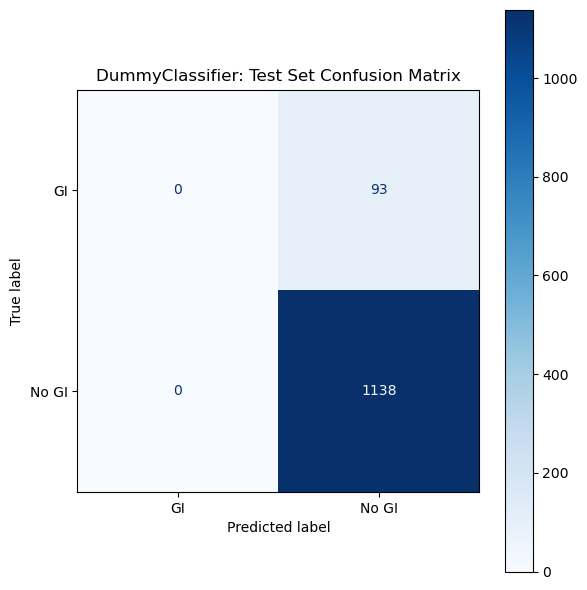

Training Logistic Regression...


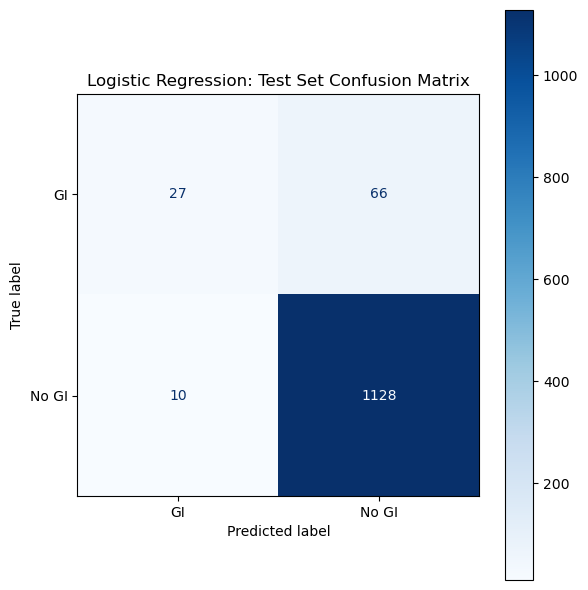

Training Random Forest...


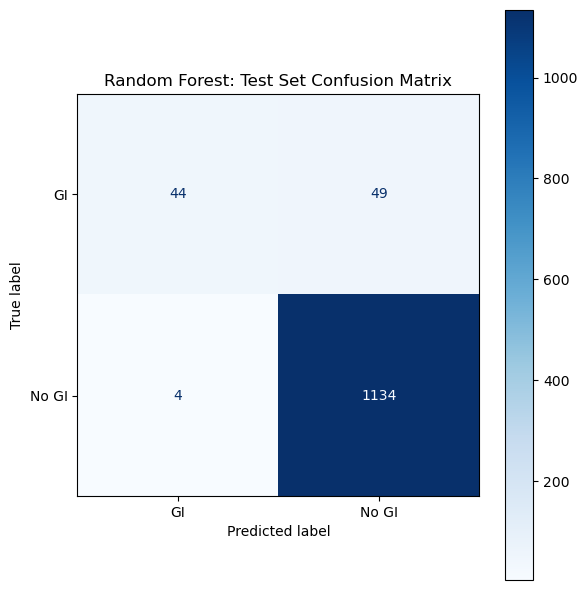

Training SVM...


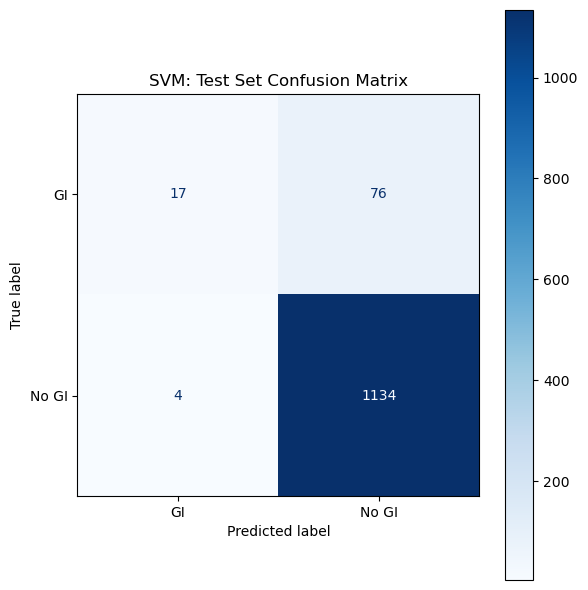

Training KNN...


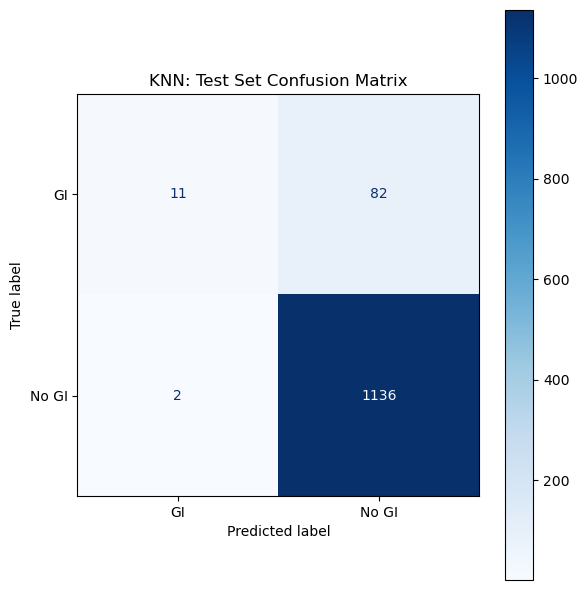

Training Naive Bayes...


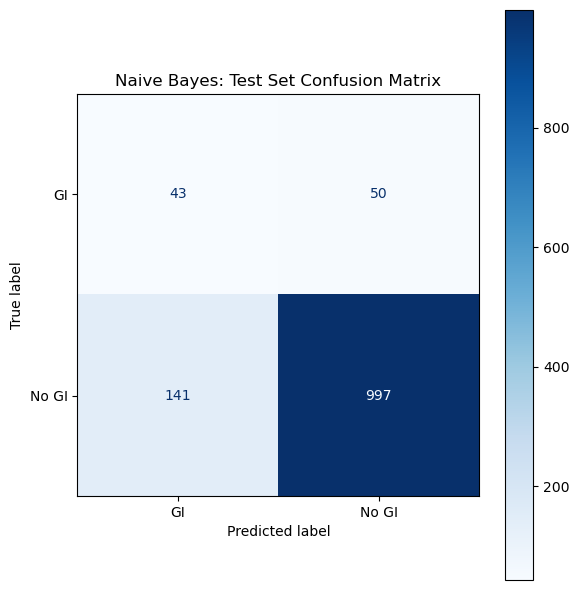

In [10]:
# Define classifiers
classifiers = {
    'DummyClassifier' :DummyClassifier(),
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),  
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    
}
# Call the function with  training,  and test sets
plot_custom_confusion_matrices_multi_classifiers(
    classifiers, 
    X_train, y_train, 
    X_test, y_test, 
    class_order=[1, 0],
    display_labels=['GI', 'No GI']  
)

# General function to plot diffrent matrixses 

In [11]:
import pandas as pd
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

def fit_and_evaluate_classifiers(classifiers, X_train, y_train, X_test, y_test, group=1):
    """
    Fit multiple classifiers, calculate performance metrics, and return a results table.
    This function relays on :
    from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

    Parameters:
    - classifiers: Dictionary of classifier names and classifier objects (e.g., {'Logistic Regression': LogisticRegression()}).
    - X_train: Training feature set.
    - y_train: Training labels.
    - X_test: Test feature set.
    - y_test: Test labels.
    - group: The class label considered as the positive class (default is 1).

    Returns:
    - Pandas DataFrame with performance metrics (AUC, Accuracy, Precision, Recall, F1-score) for each classifier.
    """
    # Ensure that we have training and testing data
    if any(data is None for data in [X_train, y_train, X_test, y_test]):
        raise ValueError("Training and testing data must be provided.")

    # Initialize a list to store the results
    results = []

    for clf_name, clf in classifiers.items():
        print(f"Training {clf_name}...")
        
        # Fit the classifier on the training data
        clf.fit(X_train, y_train)

        # Check if the classifier supports predict_proba
        if hasattr(clf, 'predict_proba'):
            y_scores = clf.predict_proba(X_test)[:, group]
            auc_value = roc_auc_score(y_test, y_scores)
        else:
            print(f"{clf_name} does not support predict_proba, skipping AUC calculation.")
            auc_value = None

        # Get predicted labels
        y_pred = clf.predict(X_test)

        # Calculate performance metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, pos_label=group, zero_division=0)
        recall = recall_score(y_test, y_pred, pos_label=group)
        f1 = f1_score(y_test, y_pred, pos_label=group)

        # Append results
        results.append({
            'Classifier': clf_name,
            'AUC': auc_value,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1
        })

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)

    # Display the results
    print("\nPerformance Metrics:")
    print(results_df)


     # Visualize the results as dots
    melted_df = results_df.melt(id_vars=['Classifier'], 
                                value_vars=['AUC', 'Accuracy', 'Precision', 'Recall', 'F1-Score'], 
                                var_name='Metric', 
                                value_name='Value')


    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=melted_df, x='Metric', y='Value', hue='Classifier', style='Classifier', s=100, palette='tab10')
    plt.title('Classifier Performance Metrics')
    plt.ylabel('Metric Value')
    plt.xlabel('Metric')
    plt.ylim(0, 1.1)  
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()



  

    return results_df


# Call the function based on the clasaffaier above to extract diffrent socres 

Training DummyClassifier...
Training Logistic Regression...
Training Random Forest...
Training SVM...
Training KNN...
Training Naive Bayes...

Performance Metrics:
            Classifier       AUC  Accuracy  Precision    Recall  F1-Score
0      DummyClassifier  0.500000  0.924452   0.000000  0.000000  0.000000
1  Logistic Regression  0.806707  0.938262   0.729730  0.290323  0.415385
2        Random Forest  0.919312  0.956946   0.916667  0.473118  0.624113
3                  SVM  0.804269  0.935012   0.809524  0.182796  0.298246
4                  KNN  0.675402  0.931763   0.846154  0.118280  0.207547
5          Naive Bayes  0.773305  0.844842   0.233696  0.462366  0.310469


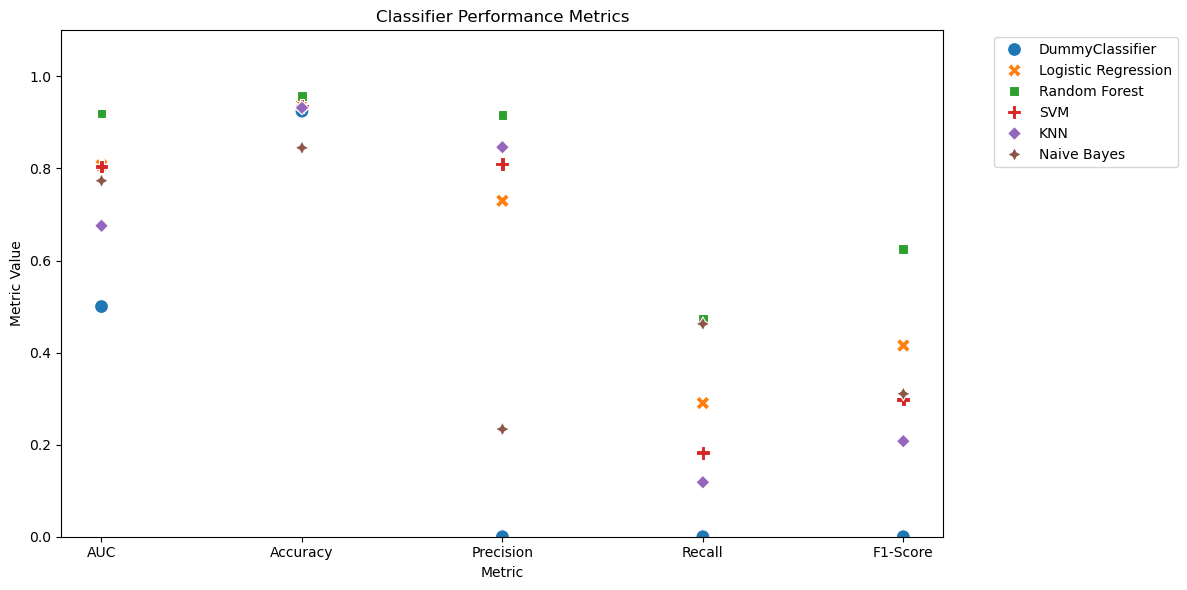

In [12]:
results_df = fit_and_evaluate_classifiers(classifiers, X_train, y_train, X_test, y_test, group=1)

In [77]:
results_df.to_csv('classifier_performance_metrics.csv', index=False)

# Write the confution matrix to axel 

In [78]:
# Export to Excel with styling
with pd.ExcelWriter('classifier_performance_metrics.xlsx', engine='xlsxwriter') as writer:
    # Write DataFrame to Excel
    results_df.to_excel(writer, sheet_name='Metrics', index=False)

    # Access the workbook and the sheet
    workbook = writer.book
    worksheet = writer.sheets['Metrics']

    # Apply header formatting
    header_format = workbook.add_format({'bold': True, 'bg_color': '#D3D3D3', 'border': 1, 'align': 'center'})
    for col_num, value in enumerate(results_df.columns.values):
        worksheet.write(0, col_num, value, header_format)

    # Apply cell formatting
    cell_format = workbook.add_format({'border': 1, 'align': 'center'})
    worksheet.set_column('A:F', 18, cell_format)

    # Adjust column widths based on content length
    for col_num, col_name in enumerate(results_df.columns):
        max_length = max(results_df[col_name].astype(str).map(len).max(), len(col_name)) + 2
        worksheet.set_column(col_num, col_num, max_length)

# General function to plot Roc curve 

In [13]:
def fit_and_plot_roc_curve_multi_classifiers(classifiers, X_train, y_train, X_test, y_test, group=1):
    """
    Function to fit multiple classifiers, plot ROC curves, and calculate AUC.
    THis function relays on:
    from sklearn.metrics import roc_curve, auc

    Parameters:
    - classifiers: Dictionary of classifier names and instances.
    - X_train: Training feature set.
    - y_train: Training labels.
    - X_test: Test feature set.
    - y_test: True labels for the test set.
    - group: The class label considered as the positive class for the ROC curve (default is 1,means GI group).
    
    Returns:
    - Plots ROC curves and AUC for each classifier.
    """
    plt.figure(figsize=(10, 8))

    for clf_name, clf in classifiers.items():
        # Fit the classifier
        clf.fit(X_train, y_train)
        
        # Ensure classifier has `predict_proba` method
        if hasattr(clf, 'predict_proba'):
            # Get the probability for the specified positive class
            y_scores = clf.predict_proba(X_test)[:, group]
        else:
            print(f"{clf_name} does not support predict_proba.")
            continue
        
        # Compute ROC curve, using 'group' as the positive class
        fpr, tpr, _ = roc_curve(y_test, y_scores, pos_label=group)
        
        # Calculate AUC
        roc_auc = auc(fpr, tpr)
        
        # Plot the ROC curve
        plt.plot(fpr, tpr, label=f'{clf_name} (AUC = {roc_auc:.2f})')

    # Plot the random guess line
    plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve Comparison')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


# Call ROC curve function

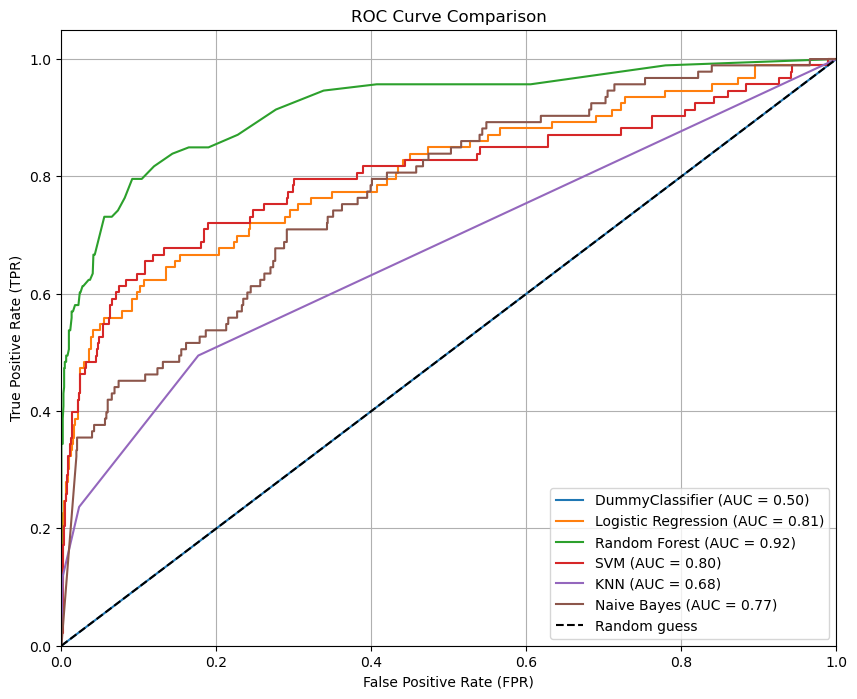

In [14]:
# Call the function to fit classifiers and plot ROC curves
fit_and_plot_roc_curve_multi_classifiers(classifiers, X_train, y_train, X_test, y_test)

# Genral function for plotting learnings curve for multi classafier 

In [81]:
def plot_learning_curves_multi_classifiers(classifiers, X_train, y_train, X_test, y_test):
    """
    Plots learning curves for multiple classifiers.
    from mlxtend.plotting import plot_learning_curves
    
    Parameters:
    - classifiers: A dictionary of classifier names and classifier objects (e.g., {'Logistic Regression': LogisticRegression()})
    - X_train: Training data features
    - y_train: Training data labels
    - X_test: Test data features
    - y_test: Test data labels
    
    Returns:
    - Plots learning curves for each classifier
    """
    for clf_name, clf in classifiers.items():
        print(f"Plotting learning curves for {clf_name}...")

        # Plot learning curves
        plt.figure(figsize=(10, 6))  
        plot_learning_curves(X_train, y_train, X_test, y_test, clf)
        
        # Set plot title
        plt.title(f'Learning Curves for {clf_name}')
        
        plt.show()

# Call the learnings curve

Plotting learning curves for DummyClassifier...


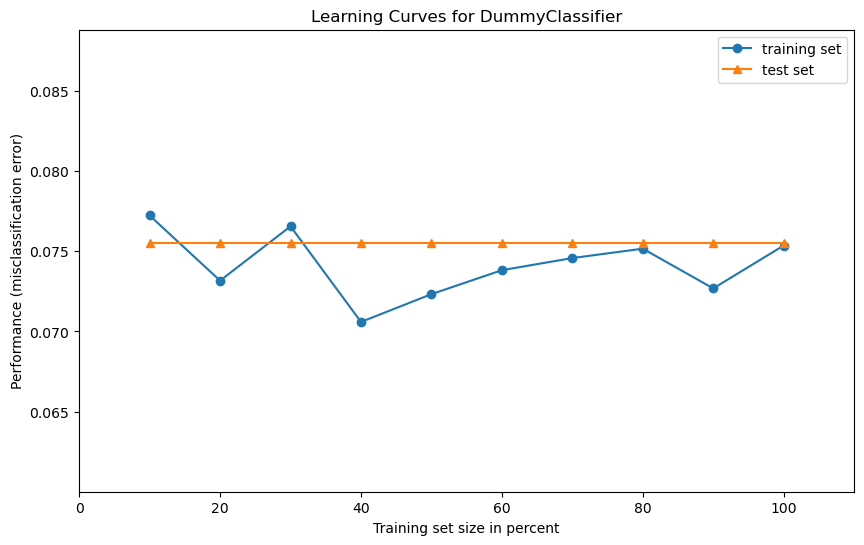

Plotting learning curves for Logistic Regression...


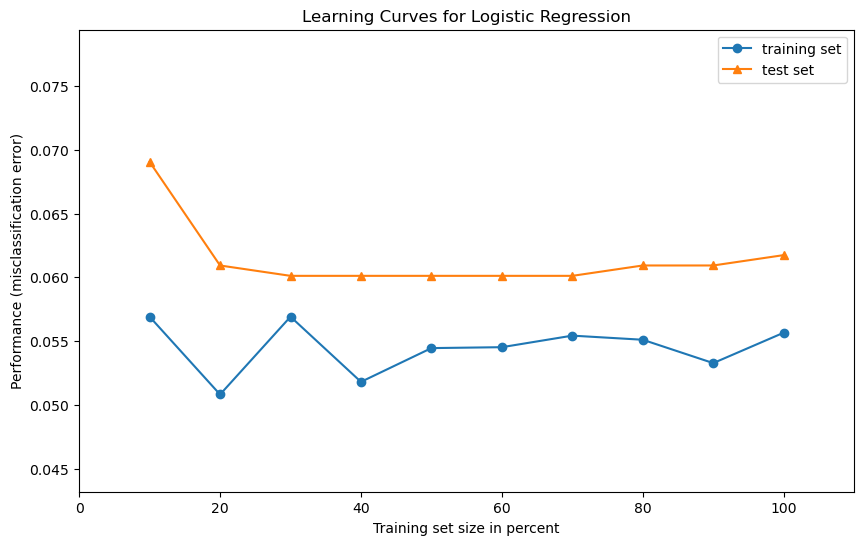

Plotting learning curves for Random Forest...


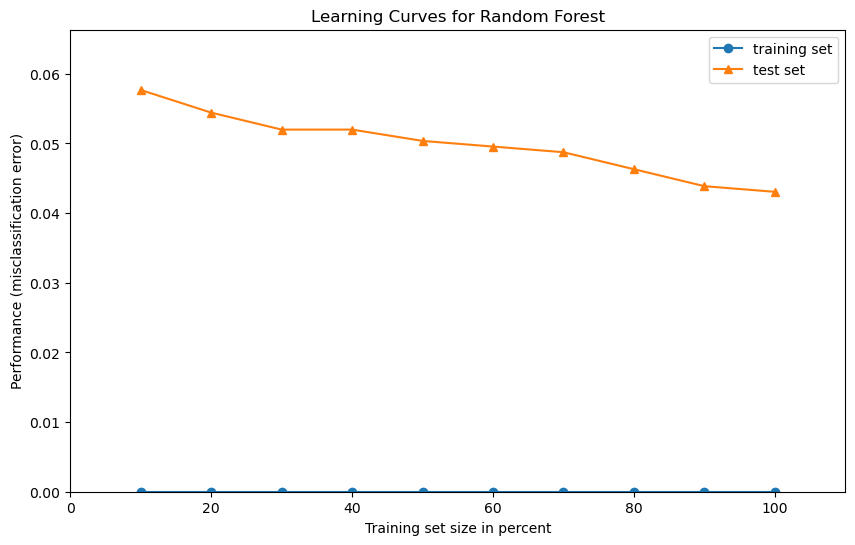

Plotting learning curves for SVM...


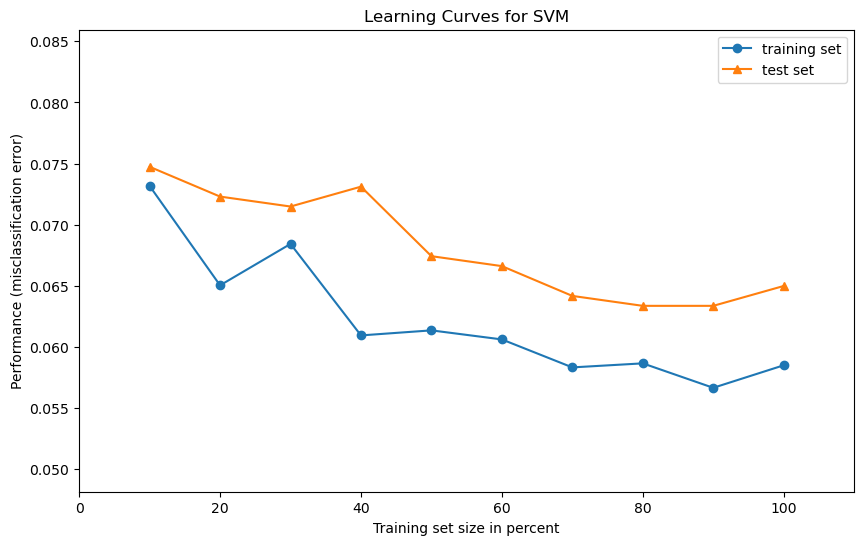

Plotting learning curves for KNN...


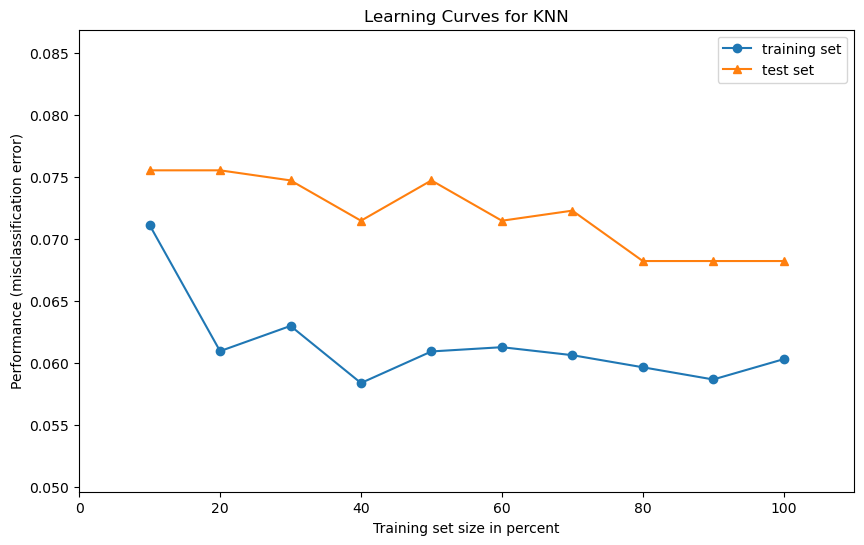

Plotting learning curves for Naive Bayes...


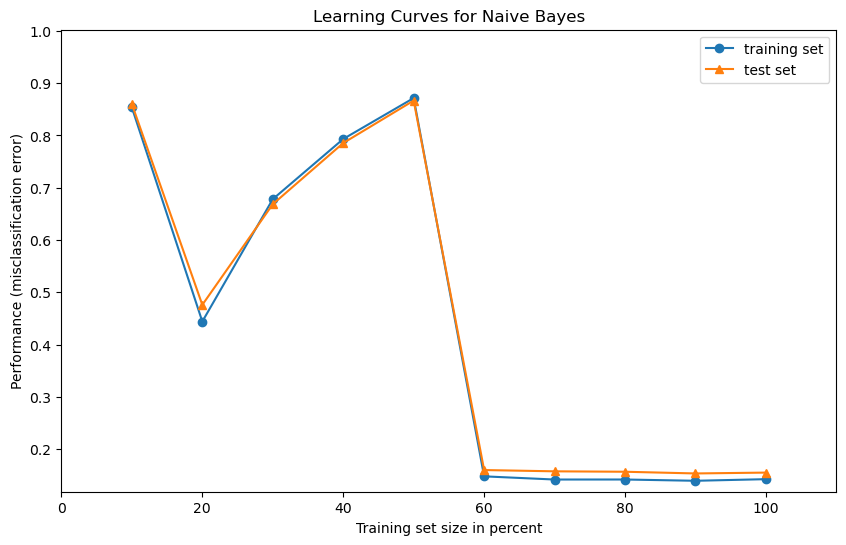

Plotting learning curves for Decision Tree...


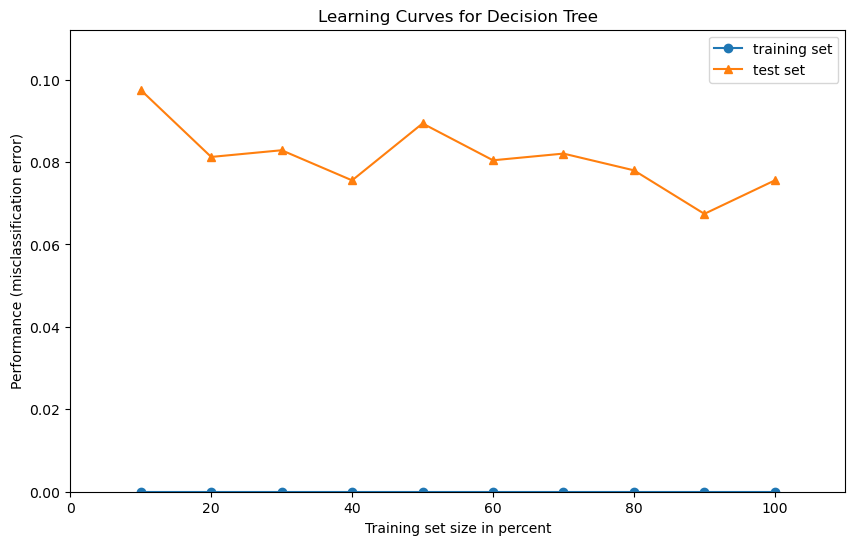

In [82]:
# Call the function to plot learning curves for each classifier
plot_learning_curves_multi_classifiers(
    classifiers, 
    X_train, y_train, 
    X_test, y_test)

# 3 - Handling inblaaced methods using diffrent methods for implance data


# Genral function to plot data size before and after oversampling

In [83]:
# Define the plot_class_distribution function
def plot_class_distribution(df, y_original, y_resampled, technique_name):
    # Extract class distribution
    original_distribution = Counter(y_original)
    resampled_distribution = Counter(y_resampled)

    # Extract class labels and counts
    classes = list(original_distribution.keys())  # Unique class labels
    original_counts = [original_distribution.get(cls, 0) for cls in classes]
    resampled_counts = [resampled_distribution.get(cls, 0) for cls in classes]

    # Create side-by-side histograms
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Original dataset histogram
    ax[0].bar(classes, original_counts, color='skyblue')
    ax[0].set_title('Original Dataset Class Distribution')
    ax[0].set_xlabel('Classes')
    ax[0].set_ylabel('Count')
    ax[0].set_xticks(classes)

    # Resampled dataset histogram
    ax[1].bar(classes, resampled_counts, color='lightgreen')
    ax[1].set_title(f'Resampled Dataset Class Distribution using {technique_name}')
    ax[1].set_xlabel('Classes')
    ax[1].set_ylabel('Count')
    ax[1].set_xticks(classes)

    # Adjust layout
    plt.tight_layout()
    plt.show()
 

# General function to train one classaafaier but with  multipel train set 


In [84]:
def plot_custom_confusion_matrices_single_classifier(
    classifier, 
    training_sets, 
    X_test, 
    y_test, 
    class_order=[1, 0], 
    display_labels=['GI', 'No GI']
):
    """
    Plots confusion matrices for a single classifier with different training datasets.
    
    Parameters:
    - classifier: A single classifier object (e.g., LogisticRegression())
    - training_sets: A dictionary where keys are dataset names (e.g., preprocessing techniques) and values are 
                     tuples (X_train, y_train) for different training datasets.
    - X_test: Test data features
    - y_test: Test data labels
    - class_order: List of class indices in desired order (default [1, 0])
    - display_labels: List of display labels in desired order (default ['GI', 'No GI'])

    Returns:
    - Plots confusion matrices for the classifier trained on each dataset.
    """
    from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
    import matplotlib.pyplot as plt

    for dataset_name, (X_train, y_train) in training_sets.items():
        print(f"Training on dataset '{dataset_name}'...")

        # Train classifier on the current training dataset
        clf = classifier
        clf.fit(X_train, y_train)
        
        # Make predictions on the test set
        y_test_pred = clf.predict(X_test)
        
        # Compute confusion matrix
        cm_test = confusion_matrix(y_test, y_test_pred)
        
        # Reorder confusion matrix based on class_order
        cm_test_reordered = cm_test[class_order][:, class_order]
        
        # Create ConfusionMatrixDisplay for the test set
        disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test_reordered, display_labels=display_labels)
        
        # Create a figure for each training dataset
        fig, ax = plt.subplots(figsize=(6, 6))
        
        # Plot test confusion matrix
        disp_test.plot(cmap=plt.cm.Blues, values_format='d', ax=ax)
        ax.set_title(f'{dataset_name}: Test Set Confusion Matrix')

        plt.tight_layout()
        plt.show()



# Function to plot diffrent sampel using one classafier 

In [85]:
def fit_and_evaluate_single_classifier(
    classifier, 
    training_sets, 
    X_test, 
    y_test, 
    group=1
):
    """
    Fit a single classifier on different training datasets, calculate performance metrics, and visualize results.

    Parameters:
    - classifier: A single classifier object (e.g., LogisticRegression()).
    - training_sets: Dictionary of training dataset names and their data tuples (e.g., {'Original': (X_train, y_train)}).
    - X_test: Test feature set.
    - y_test: Test labels.
    - group: The class label considered as the positive class (default is 1).

    Returns:
    - Pandas DataFrame with performance metrics (AUC, Accuracy, Precision, Recall, F1-score) for each dataset.
    """
    from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Check for training and testing data
    if any(data is None for data in [X_test, y_test]):
        raise ValueError("Test data must be provided.")
    if not training_sets:
        raise ValueError("Training sets must be provided.")
    
    # Initialize a list to store results
    results = []

    for dataset_name, (X_train, y_train) in training_sets.items():
        print(f"Training on dataset: '{dataset_name}'")

        # Fit the classifier on the current training data
        clf = classifier
        clf.fit(X_train, y_train)

        # Calculate AUC if supported
        if hasattr(clf, 'predict_proba'):
            y_scores = clf.predict_proba(X_test)[:, group]
            auc_value = roc_auc_score(y_test, y_scores)
        else:
            print(f"{type(clf).__name__} does not support predict_proba, skipping AUC calculation.")
            auc_value = None

        # Get predicted labels
        y_pred = clf.predict(X_test)

        # Calculate performance metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, pos_label=group, zero_division=0)
        recall = recall_score(y_test, y_pred, pos_label=group)
        f1 = f1_score(y_test, y_pred, pos_label=group)

        # Append results with dataset name
        results.append({
            'Dataset': dataset_name,
            'AUC': auc_value,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1
        })

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)

    # Display the results
    print("\nPerformance Metrics:")
    print(results_df)

    # Visualize the results as scatter plots
    melted_df = results_df.melt(id_vars=['Dataset'], 
                                value_vars=['AUC', 'Accuracy', 'Precision', 'Recall', 'F1-Score'], 
                                var_name='Metric', 
                                value_name='Value')

    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        data=melted_df, 
        x='Metric', 
        y='Value', 
        hue='Dataset', 
        style='Dataset', 
        s=100, 
        palette='tab10'
    )
    plt.title('Classifier Performance Metrics Across Datasets')
    plt.ylabel('Metric Value')
    plt.xlabel('Metric')
    plt.ylim(0, 1.1)  
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Dataset')
    plt.tight_layout()
    plt.show()

    return results_df



# A ) Random over-sampling with imblearn

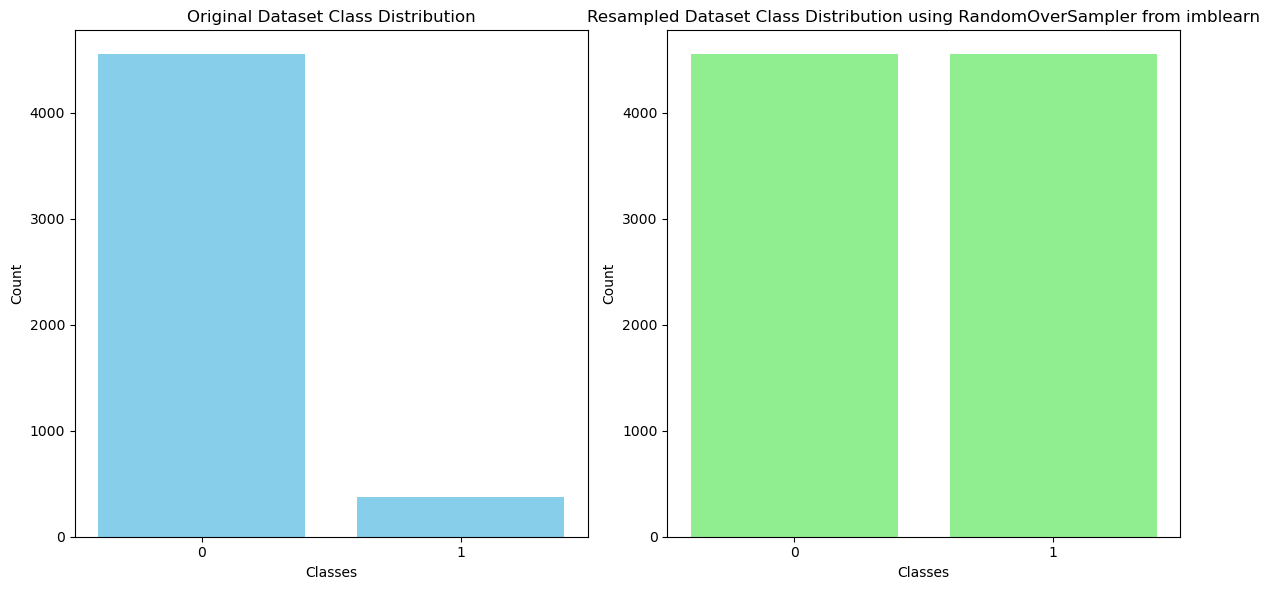

In [86]:

# Define classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(random_state=42),
}
# Initialize RandomOverSampler
ros = RandomOverSampler()
# Perform random oversampling (use fit_resample instead of fit_sample)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

# plot using the  plot_class_distribution function:
plot_class_distribution(filtered_df, y_train, y_train_ros, "RandomOverSampler from imblearn")




# 2 Synthetic Minority Oversampling Technique (SMOTE)
'''SMOTE algorithm works in 4 simple steps:

Choose a minority class as the input vector
Find its k nearest neighbors (k_neighbors is specified as an argument in the SMOTE() function)
Choose one of these neighbors and place a synthetic point anywhere on the line joining the point under consideration and its chosen neighbor
Repeat the steps until data is balanced'''

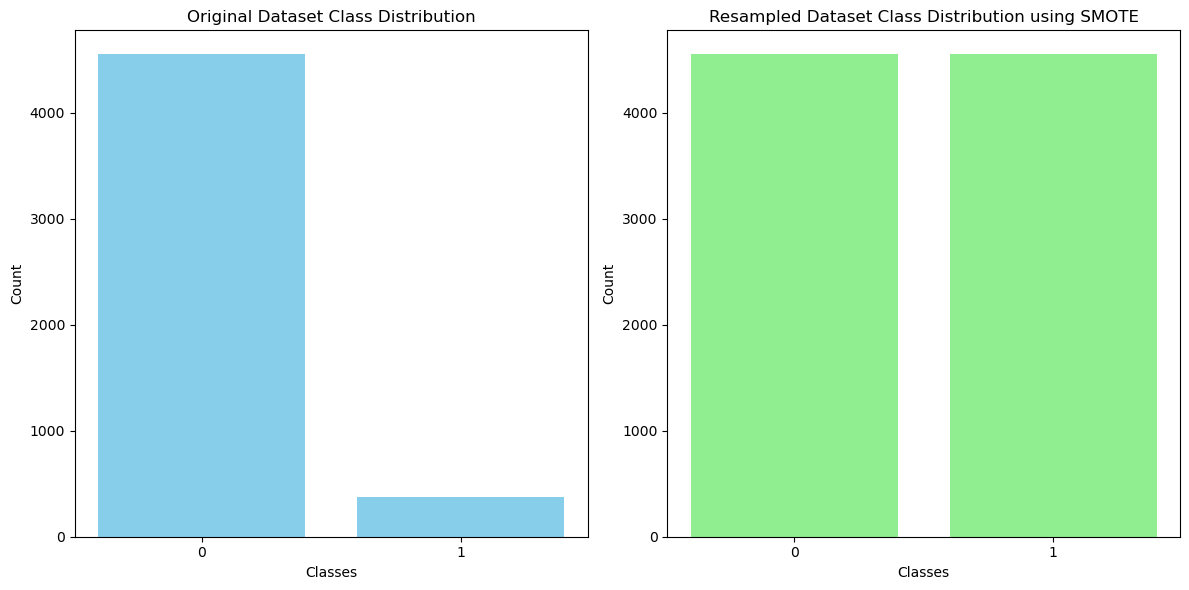

In [87]:
# from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTE

# create the  object with the desired sampling strategy.
smote = SMOTE(sampling_strategy='minority',random_state=42)

# fit the object to our training data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# plot using the  plot_class_distribution function:
plot_class_distribution(df1,y_train, y_train_smote, "SMOTE")



# 3- Borderline-SMOTE
1- classafy majorit and minority class
2-Select the misclassafication class by using KNN for exampel if it is 3 it will draw line between 3 neigboring data and it will attach to other group it will misclassafiy.This is means the data in the border will be misclassafyfrom minority class
3- it will add new syntatatic point to misclalassafied point using SMOTE (multiplipcated a random number between 0 and 1)
Borderline-SMOTE1 (as discribed early )
Borderline-SMOTE2 (step 2 focusin both class and using the nuber between 0 and 0,5)

The assumption is that these borderline instances are more informative for the classifier, so augmenting them with synthetic data helps the model better learn the decision boundary.

# Why Add Synthetic Points Near the Border:
Improve decision boundary: By adding synthetic points near the border, BORDLINE-SMOTE helps to better define the boundary between the majority and minority classes, allowing classifiers to learn a more accurate separation.

Reduce misclassification: Classifiers often misclassify minority samples near the boundary as majority samples. By enriching this region with synthetic samples, the classifier is better trained to correctly classify borderline minority instances.

Address imbalance in critical areas: Traditional SMOTE may oversample areas far from the decision boundary, which may not contribute to improved classification performance. BORDLINE-SMOTE targets the critical regions near the boundary where the classification problem is more challenging.



# The drawback of this method 
1- Noisy data near the decision boundary:
Some of these samples might be outliers, mislabelled data, or simply noisy instances 

# Solutions to Mitigate This Problem:


1-Tomek Links (BORDLINE-SMOTE + Tomek Links):

 can be used after BORDLINE-SMOTE to identify and remove borderline instances that are too close to majority class instances. A Tomek Link exists when two nearest neighbor instances belong to different classes. By removing these pairs, you can clean up noisy samples that are too close to the boundary, reducing overlap between classes.
2- Cleaning techniques (Edited Nearest Neighbors, ENN):

3-Techniques like Edited Nearest Neighbors (ENN) can be applied before BORDLINE-SMOTE to clean up noisy data points. ENN removes samples that are misclassified by their nearest neighbors, which helps in filtering out noisy or misclassified data points before generating synthetic samples.
Adaptive SMOTE (ADASYN):

4-ADASYN (Adaptive Synthetic Sampling) is another variant of SMOTE that addresses this issue by generating more synthetic points in areas where there are fewer minority class samples, and fewer synthetic points in denser minority regions. It focuses on difficult-to-learn examples but attempts to reduce the risk of oversampling noisy borderline points.
Advanced Outlier Detection:

5-Implementing an outlier detection mechanism before applying BORDLINE-SMOTE can help detect and remove potential noisy or mislabelled samples. Techniques like Local Outlier Factor (LOF) or Isolation Forests can help flag these outliers for removal.
Borderline-SMOTE2:

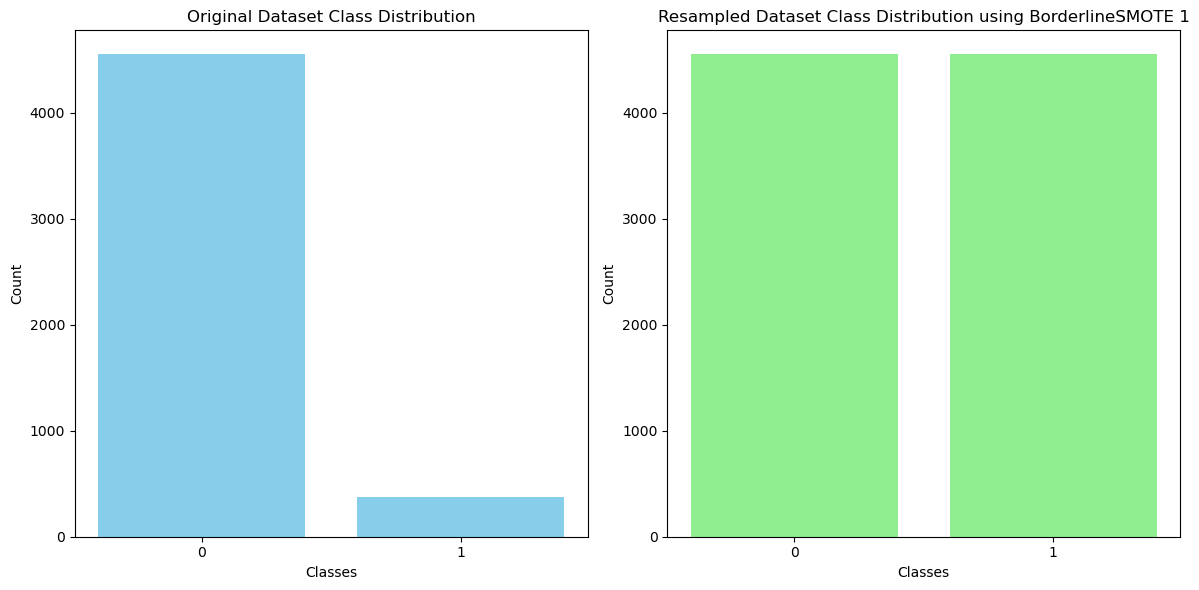

In [88]:
# from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import BorderlineSMOTE

# fit the object to our training data
bsmote1 = BorderlineSMOTE(kind = 'borderline-1',sampling_strategy='minority',random_state = 42)

# fit the object to our training data
X_train_bsmote1, y_train_bsmote1 = bsmote1.fit_resample(X_train, y_train)

# plot using the  plot_class_distribution function:
plot_class_distribution(filtered_df, y_train, y_train_bsmote1, "BorderlineSMOTE 1")

# 4_ BorderlineSMOTE 2

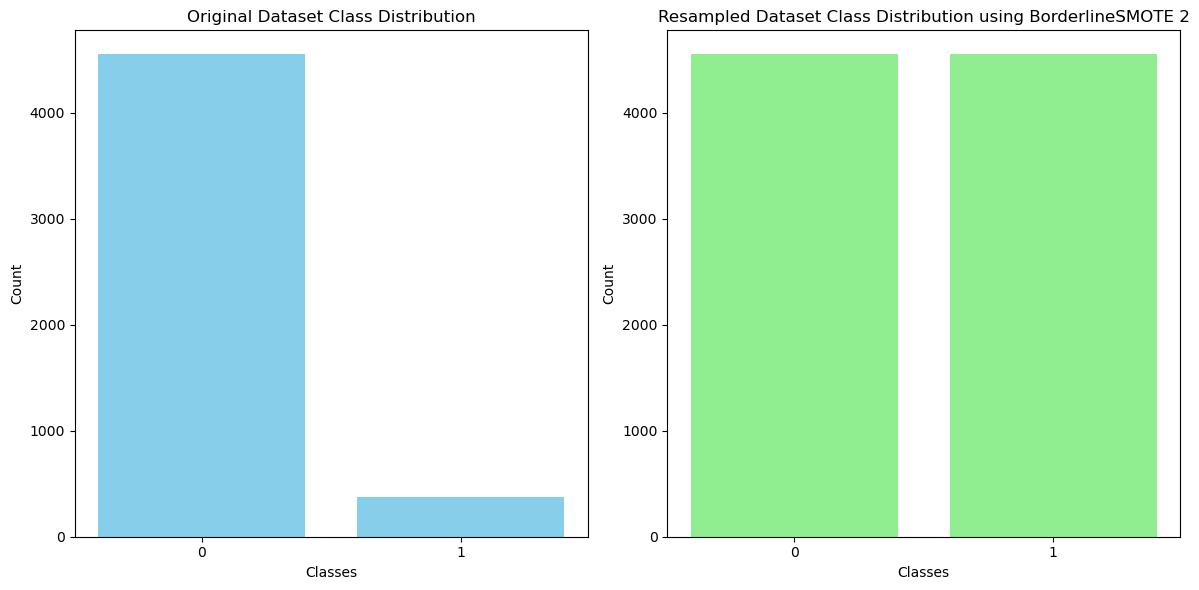

In [89]:
# Initialize the BorderlineSMOTE object
bsmote2 = BorderlineSMOTE(kind='borderline-2', sampling_strategy='minority', random_state=42)

# Apply BorderlineSMOTE to the training data
X_train_bsmote2, y_train_bsmote2 = bsmote2.fit_resample(X_train, y_train)


# plot using the  plot_class_distribution function:
plot_class_distribution(filtered_df,y_train, y_train_bsmote2,"BorderlineSMOTE 2")


# 5- Borderline-SMOTE SVM

In the SVM-SMOTE, the borderline area is approximated by the support vectors (maximizing the area between two classes ) after training SVMs classifier on the original training set. Synthetic data will be randomly created along the lines joining each minority class support vector with a number of its nearest neighbors. What special about Borderline-SMOTE SVM compared to the Borderline-SMOTE is that more data are synthesized away from the region of class overlap. It focuses more on where the data is separated.
The focus lyes on between where minumm class found, compared to the border.


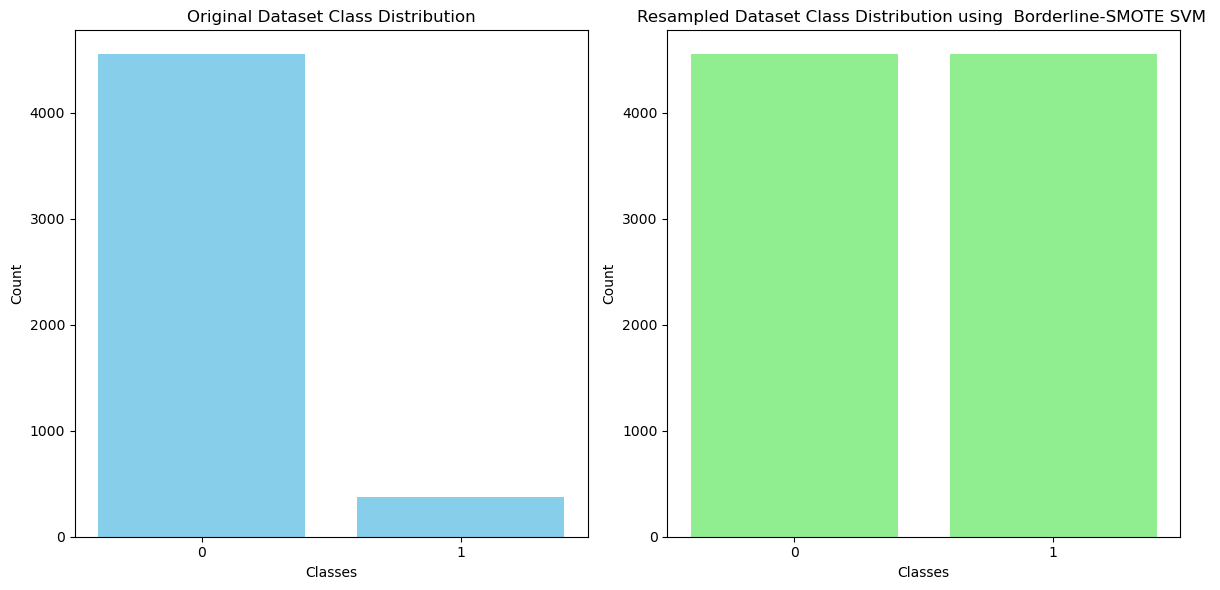

In [90]:
# from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import SVMSMOTE
# applay svmsmote
svmsmote = SVMSMOTE(sampling_strategy='minority',random_state = 42)
# fit the object to our training data
X_train_svmsmote, y_train_svmsmote= svmsmote.fit_resample(X_train, y_train)

# plot using the  plot_class_distribution function:
plot_class_distribution(filtered_df,y_train, y_train_svmsmote," Borderline-SMOTE SVM ")

# 6- KMeansSMOTE

K-Means SMOTE works in three steps:

Cluster the entire input space using k-means.
Distribute the number of samples to generate across clusters:
Select clusters which have a high number of minority class samples.
Assign more synthetic samples to clusters where minority class samples are sparsely distributed.
Oversample each filtered cluster using SMOTE.

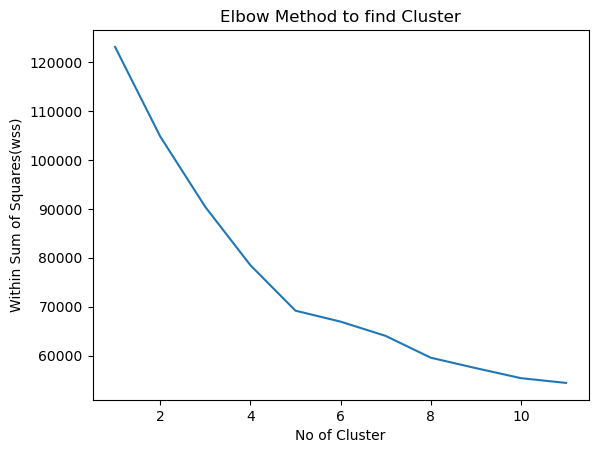

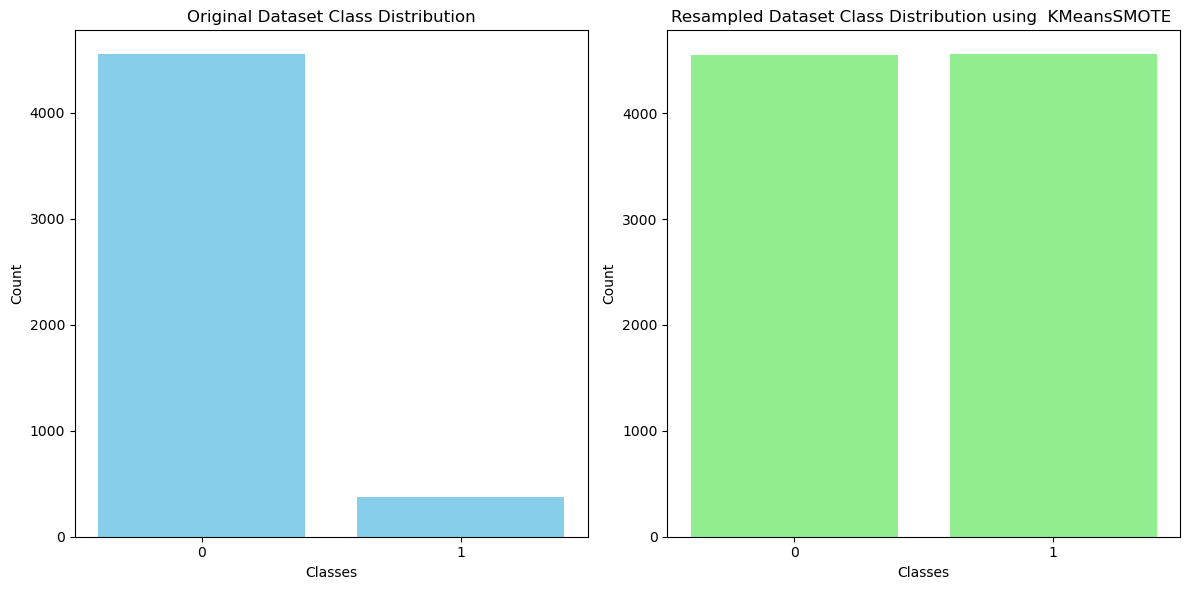

In [91]:
from imblearn.over_sampling import KMeansSMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

scale = StandardScaler()
X_train_scale = scale.fit_transform(X_train)

### Elbow method to find the No of cluster using WSS
wss = []
cluster = list(range(1,12))

for k in cluster:
    kmean = KMeans(n_clusters= k,init="k-means++",random_state = 42)
    kmean.fit(X_train_scale)
    wss.append(kmean.inertia_)

plt.title("Elbow Method to find Cluster")
sns.lineplot(x=cluster,y=wss)
plt.ylabel("Within Sum of Squares(wss)")
plt.xlabel("No of Cluster")

ksmote = KMeansSMOTE(
    sampling_strategy='minority',
    k_neighbors=2,
    kmeans_estimator=4,
    cluster_balance_threshold=0.02,
    density_exponent='auto')

# fit the object to our training data
X_train_ksmote, y_train_ksmote = ksmote.fit_resample(X_train, y_train)

# plot using the  plot_class_distribution function:
plot_class_distribution(filtered_df,y_train, y_train_ksmote," KMeansSMOTE ")




# 7- Oversampling with Adaptive Synthetic sampling(ADASYN)


It measures the K-nearest neighbors for all minority instances, then calculates the class ratio of the minority and majority instances to create new samples. Repeating this process, we will adaptively shift the decision boundary to focus on those samples that are hard to learn. The synthetic data generation would inversely proportional to the density of the minority class. It means more synthetic data are created in regions of the feature space where the density of minority examples is low, and fewer or none where the density is high. In simpler terms, in an area where the minority class is less dense, the synthetic data are created more. Otherwise, the synthetic data is not made so much.

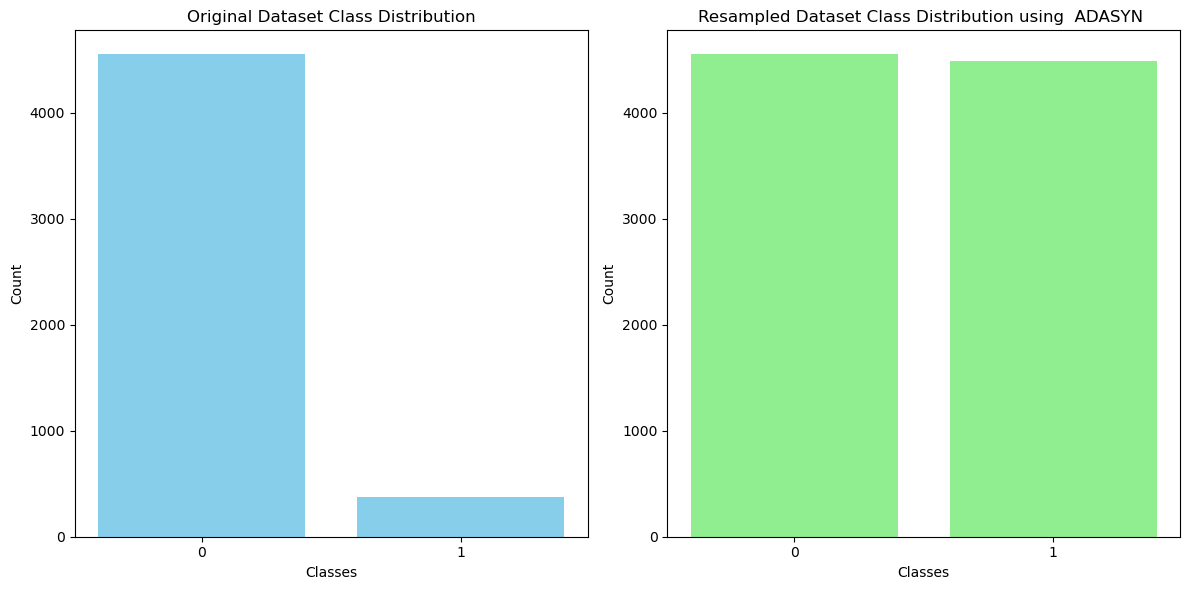

In [92]:
# from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import ADASYN

# create the object to resample the majority class.
adasyn = ADASYN(sampling_strategy="minority",random_state=42)

# fit the object to the training data.
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)

# plot using the  plot_class_distribution function:
plot_class_distribution(filtered_df,y_train, y_train_adasyn," ADASYN ")

# 8_TomekLinks
Undersamplings method to remove the majority class in border 

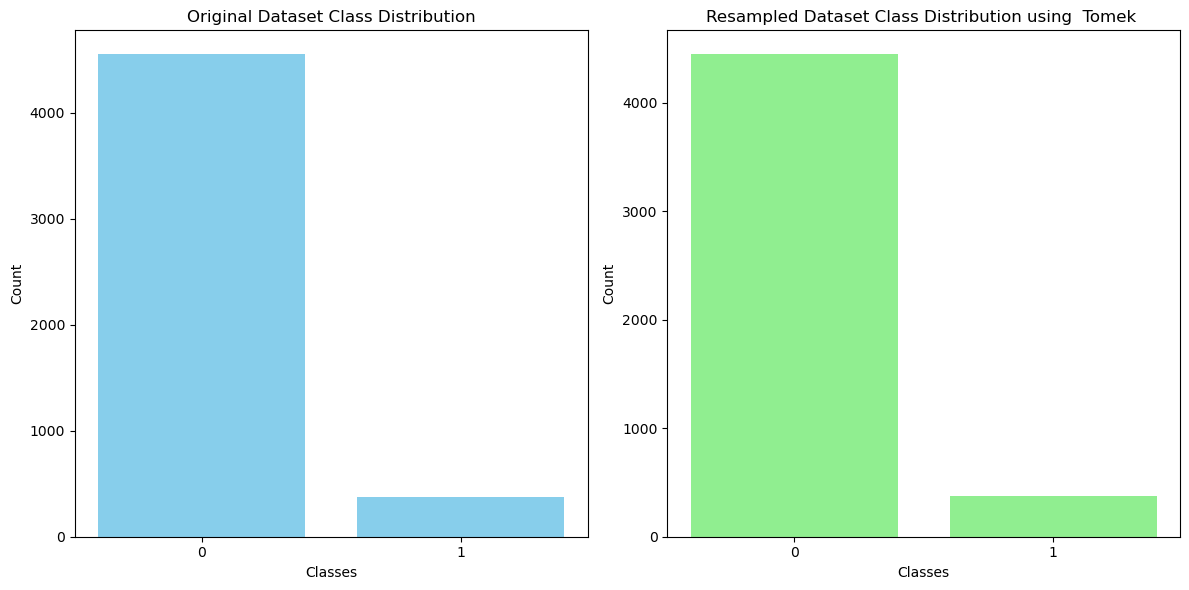

In [93]:
# from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import TomekLinks
# Apply Tomek Links to clean training data
tomek = TomekLinks()
X_tomek, y_tomek = tomek.fit_resample(X_train, y_train)

# plot using the  plot_class_distribution function:
plot_class_distribution(filtered_df,y_train, y_tomek," Tomek ")

#  9-k-nearest neighbors (KNN)
Nearest Neighbors: ENN uses the k-nearest neighbors (KNN) algorithm to decide whether to remove a sample. It checks each instance in the dataset against its nearest neighbors.

Noise Reduction: If a sample's class label differs from the majority of its nearest neighbors, the sample is considered noisy and is removed from the dataset.

Class Boundary Refinement: By removing noisy samples, ENN helps to smooth the class boundaries, making it easier for a classifier to distinguish between different classes.

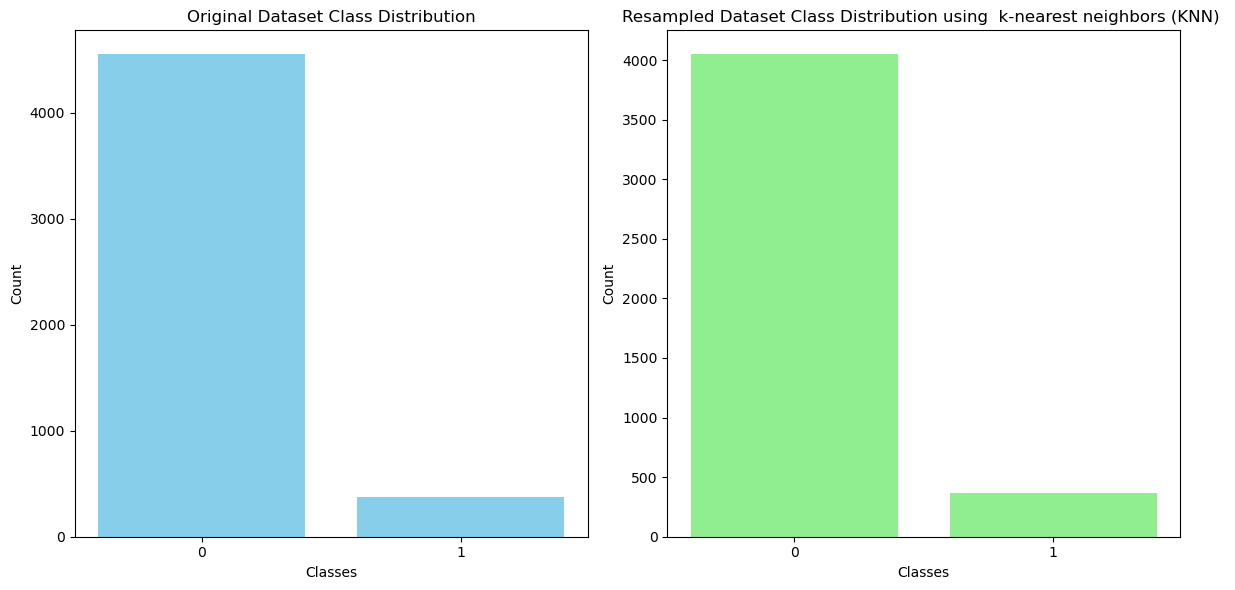

In [94]:
# from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import EditedNearestNeighbours
# : Apply Edited Nearest Neighbors (ENN)

enn = EditedNearestNeighbours(n_neighbors=3)  
X_enn, y_enn = enn.fit_resample(X_train, y_train)

# plot using the  plot_class_distribution function:
plot_class_distribution(filtered_df,y_train, y_enn," k-nearest neighbors (KNN) ")

 # 10- tomek undersamplingmethod for cleaning + oversamling using BorderlineSMOTE 1 

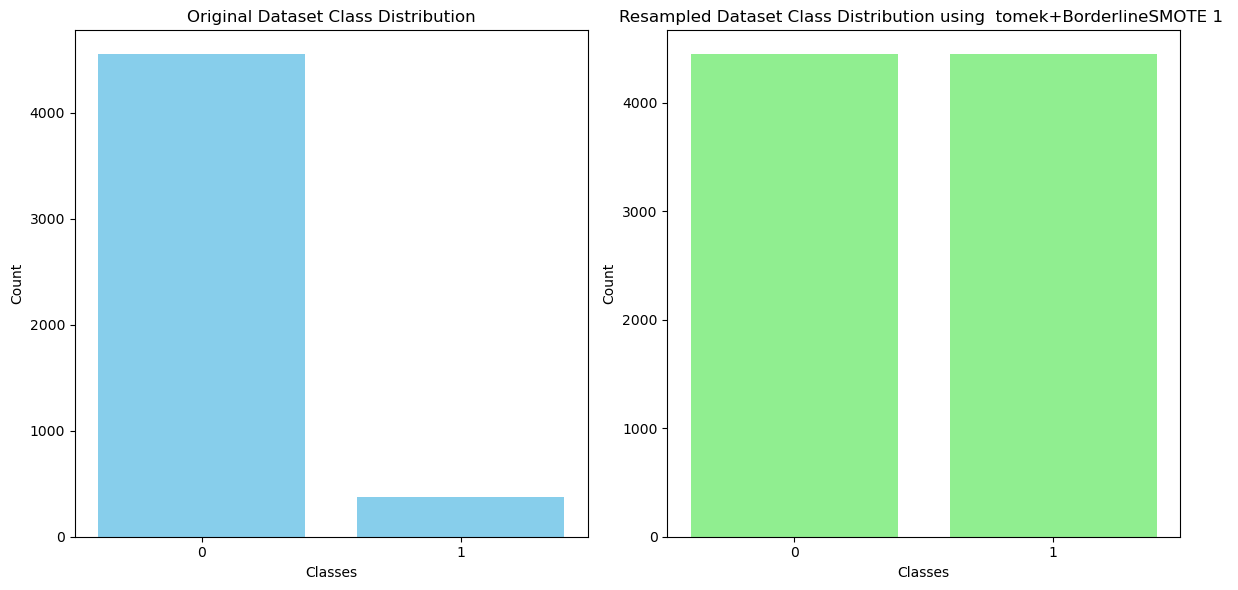

In [95]:
# from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import TomekLinks

# Apply Tomek Links to clean training data
tomek = TomekLinks()
X_tomek, y_tomek = tomek.fit_resample(X_train, y_train)


# fit the object to our training data
bsmote1 = BorderlineSMOTE(kind = 'borderline-1',sampling_strategy='minority',random_state = 42)

# fit the object to our training data
X_train_bsmote1_tomek, y_train_bsmote1_tomek = bsmote1.fit_resample(X_tomek, y_tomek)
# plot using the  plot_class_distribution function:
plot_class_distribution(filtered_df,y_train,y_train_bsmote1_tomek ," tomek+BorderlineSMOTE 1 ")



Training on dataset 'Original Data'...


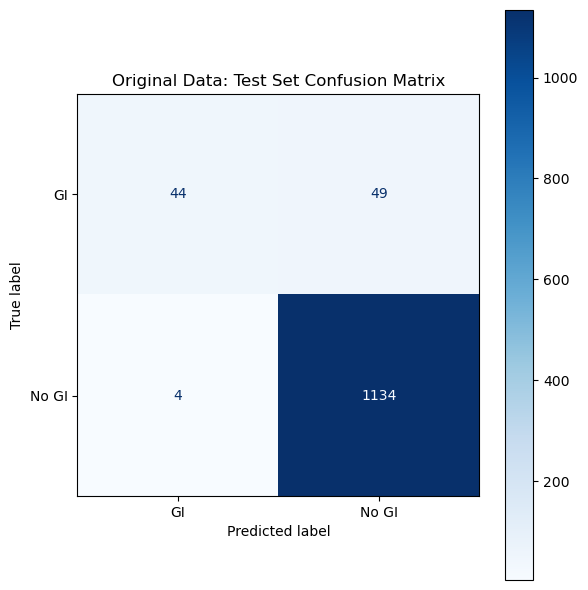

Training on dataset 'RandomOverSampler'...


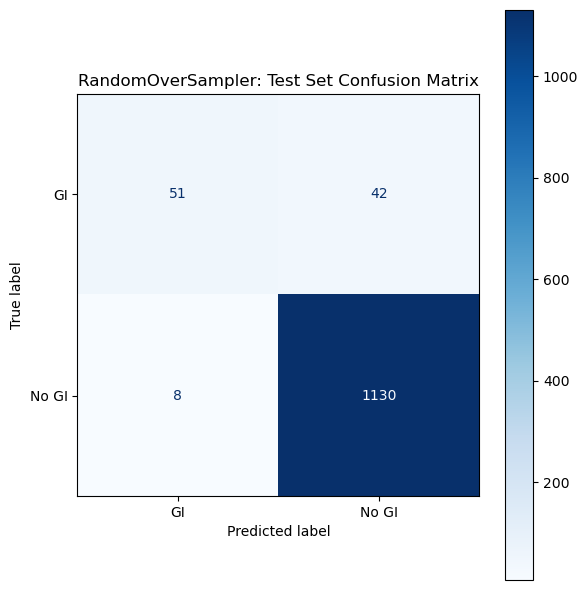

Training on dataset 'SMOTE'...


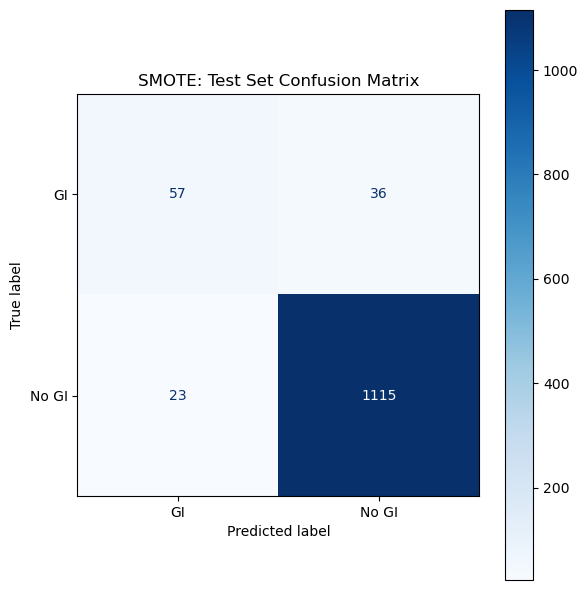

Training on dataset 'BorderlineSMOTE 1'...


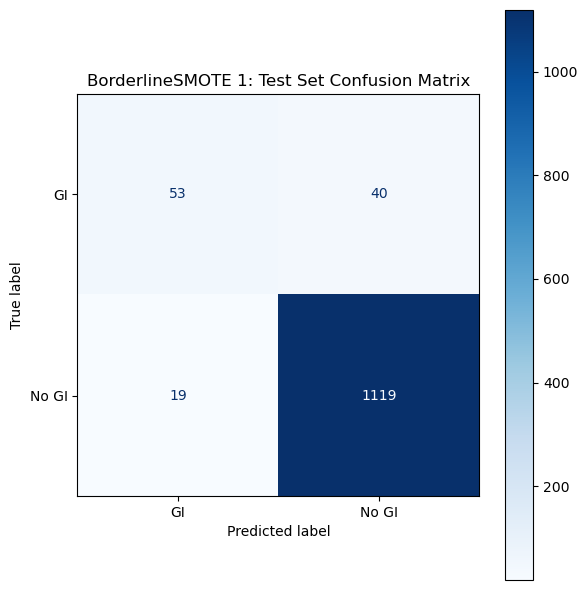

Training on dataset 'BorderlineSMOTE 2'...


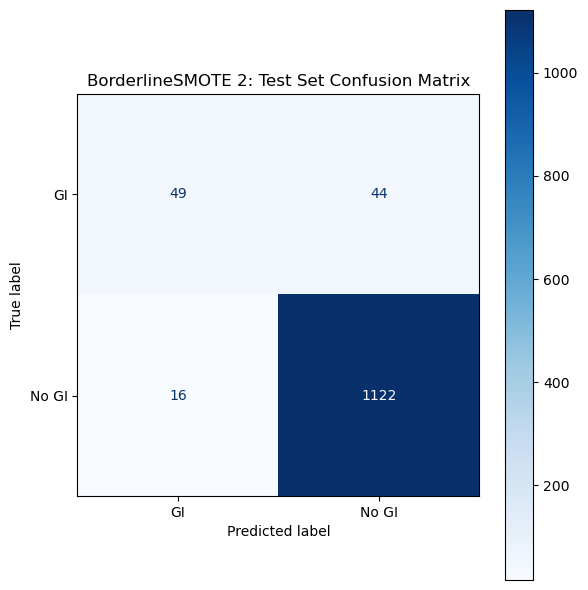

Training on dataset 'Borderline-SMOTE SVM '...


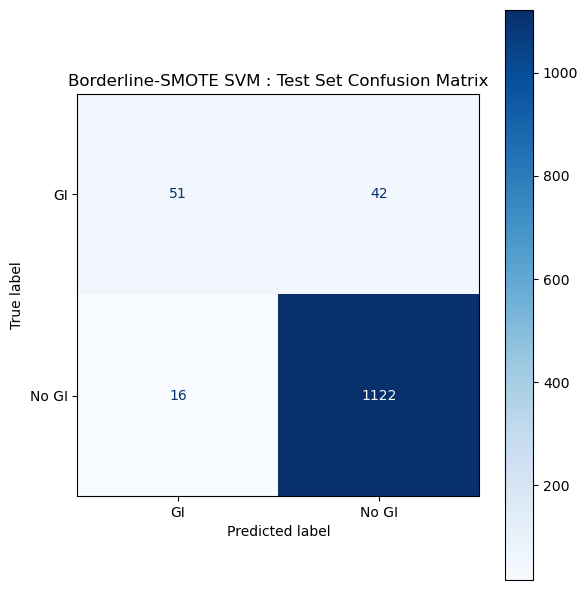

Training on dataset ' Borderline-SMOTE SVM'...


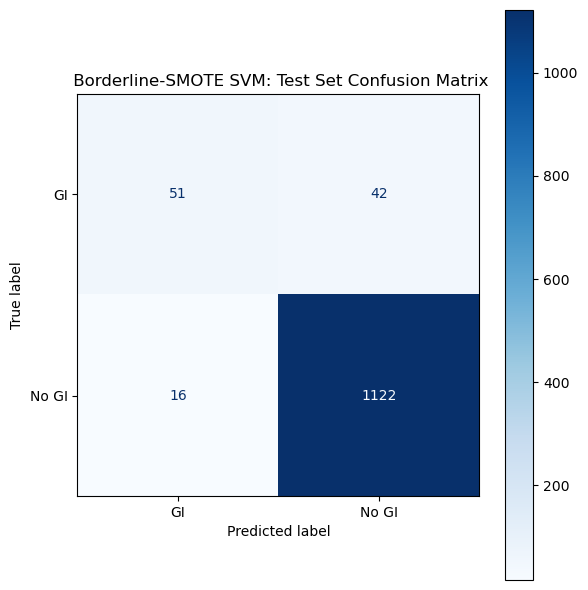

Training on dataset 'KMeansSMOTE'...


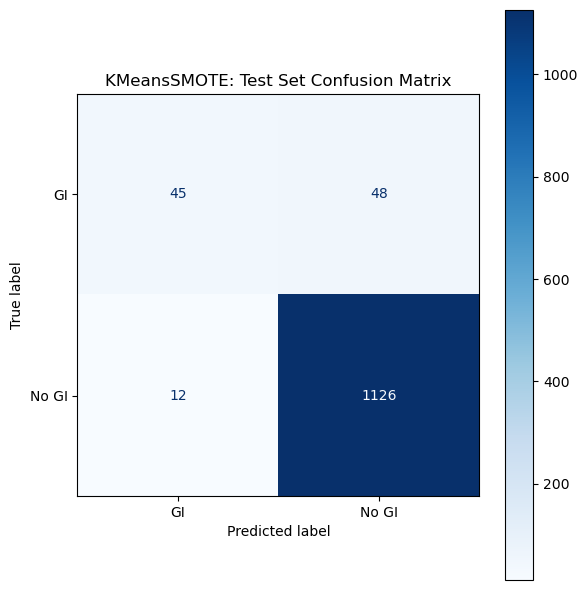

Training on dataset 'ADASYN'...


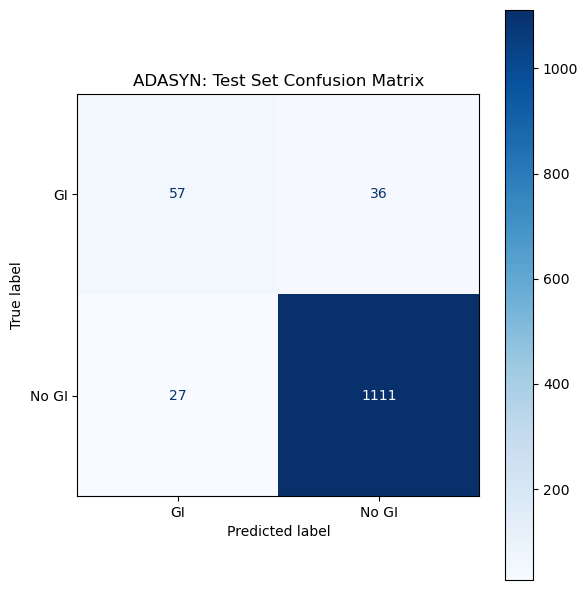

Training on dataset 'Tomek'...


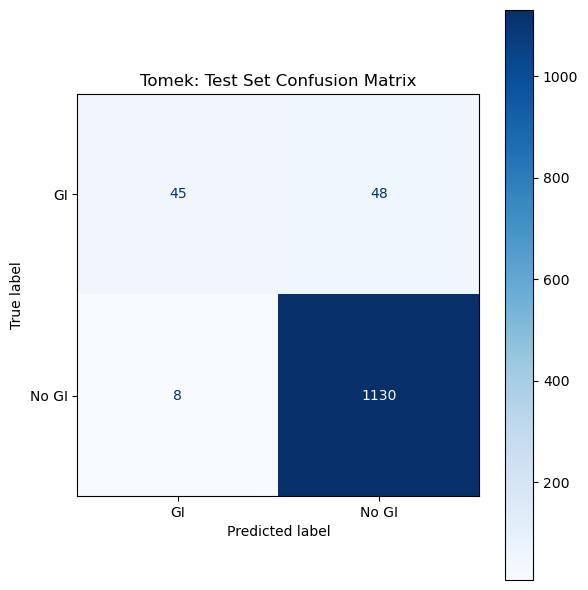

Training on dataset 'k-nearest neighbors (KNN)'...


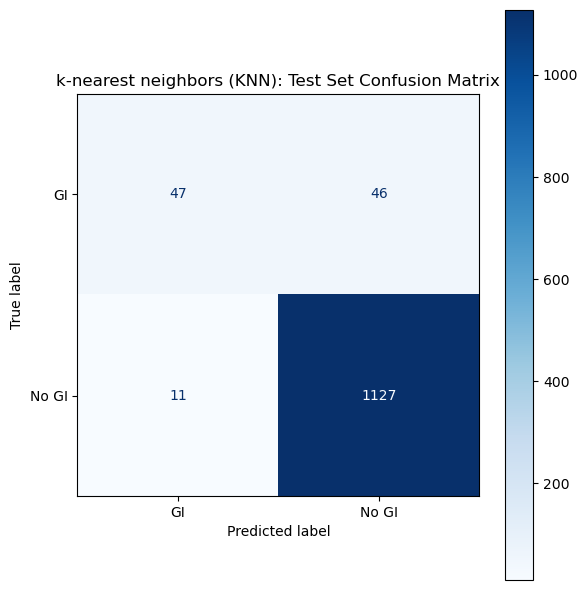

Training on dataset 'tomek+BorderlineSMOTE 1'...


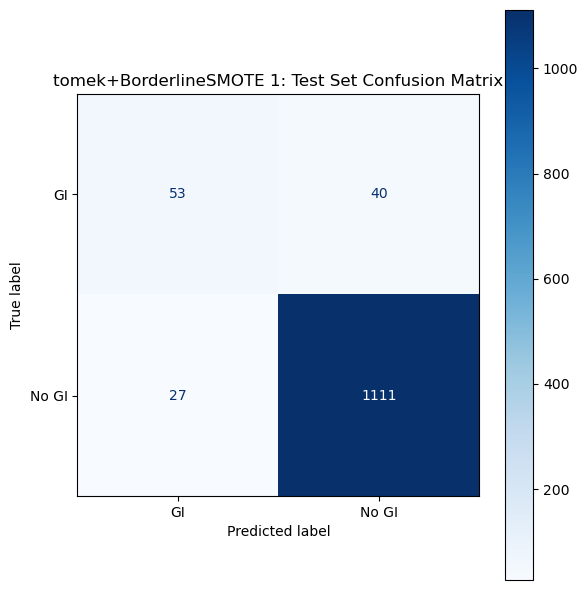

In [96]:
# Dictionary of training datasets
training_sets = {
    'Original Data': (X_train, y_train),
    'RandomOverSampler': (X_train_ros, y_train_ros),
    'SMOTE'   :(X_train_smote, y_train_smote),
    'BorderlineSMOTE 1':(X_train_bsmote1, y_train_bsmote1 ),
    'BorderlineSMOTE 2':(X_train_bsmote2, y_train_bsmote2 ),
    'Borderline-SMOTE SVM ':(X_train_svmsmote, y_train_svmsmote),
    ' Borderline-SMOTE SVM':(X_train_svmsmote,y_train_svmsmote),
    'KMeansSMOTE':(X_train_ksmote, y_train_ksmote ),
    'ADASYN': (X_train_adasyn, y_train_adasyn),
    'Tomek': (X_tomek, y_tomek),
    'k-nearest neighbors (KNN)': (X_enn, y_enn ),
    'tomek+BorderlineSMOTE 1':(X_train_bsmote1_tomek, y_train_bsmote1_tomek )
    }

# Single classifier
classifier =  RandomForestClassifier(random_state=42)

# Call the function
plot_custom_confusion_matrices_single_classifier(
    classifier=classifier,
    training_sets=training_sets,
    X_test=X_test,
    y_test=y_test
)

# Call the function for diffrance matrixes using Randomforest 

Training on dataset: 'Original Data'
Training on dataset: 'RandomOverSampler'
Training on dataset: 'SMOTE'
Training on dataset: 'BorderlineSMOTE 1'
Training on dataset: 'BorderlineSMOTE 2'
Training on dataset: 'Borderline-SMOTE SVM '
Training on dataset: ' Borderline-SMOTE SVM'
Training on dataset: 'KMeansSMOTE'
Training on dataset: 'ADASYN'
Training on dataset: 'Tomek'
Training on dataset: 'k-nearest neighbors (KNN)'
Training on dataset: 'tomek+BorderlineSMOTE 1'

Performance Metrics:
                      Dataset       AUC  Accuracy  Precision    Recall  \
0               Original Data  0.919312  0.956946   0.916667  0.473118   
1           RandomOverSampler  0.930566  0.959383   0.864407  0.548387   
2                       SMOTE  0.918623  0.952071   0.712500  0.612903   
3           BorderlineSMOTE 1  0.904605  0.952071   0.736111  0.569892   
4           BorderlineSMOTE 2  0.907426  0.951259   0.753846  0.526882   
5       Borderline-SMOTE SVM   0.912108  0.952884   0.761194  0.5

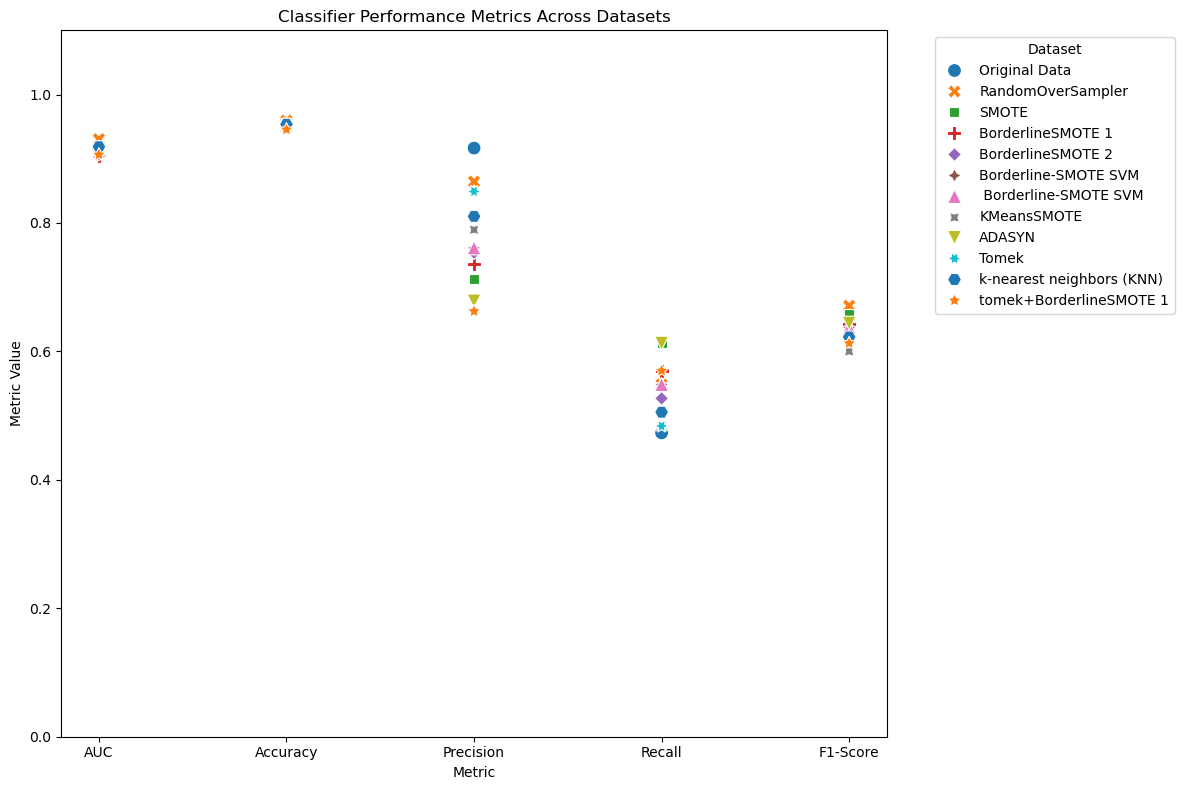

In [97]:
# Call the function
results_df = fit_and_evaluate_single_classifier(
    classifier=classifier, 
    training_sets=training_sets, 
    X_test=X_test, 
    y_test=y_test
)

# Create general function that can discover which moste predictive features
In this function the Randomforest classafoer will be trained, aftethat Feature importances calculated  based on the mean decrease in impurity are computed using model.feature_importances_. The standard deviation of feature importances across all trees in the random forest is computed using np.std(). The output will be  a bar chart with values.

INthe second, the permutation_importance() function is used to compute feature importance based on accuracy. It used n_repeats=10 ,meaning the every features shuffeled 10 times and calculted the performance , and afterthat calculated the means of the perfomance. It will used accuracy and F1 score for the prediction of moste predictive featiure. It is used Gini impurity


They are two ways used to discover most predictive features, MDI (Mean Decrease in Impurity), it messure the feature importance based on how the feature reduce the impuritey when it split the sampels in the tree.
For each tree, the importance of a feature is computed by summing the reduction in impurity for all splits where that feature was used.THen the feature importance across all trees is averaged to give the final importance score for each feature

 Permutation Importance calculated by train the model in the classafeir, Calculate the baseline performance, Shuffle the values of one feature ,After shuffling the feature values, the model is re-evaluated on the modified test set to see how the performance changes.
 The decrease in performance is calculated by comparing the model's performance on the shuffled test set to the baseline performance. The greater the performance decrease, the more important the feature is.

 MDI is more senseitive the more correlated features but Permutation is more restrictive against correlated features. 


In [98]:
def feature_importance_analysis(X_train, y_train, X_test, y_test):

    """
    Perform feature importance analysis using both Mean Decrease in Impurity (MDI) and Permutation Importance
    on a Random Forest model. The function trains the model, calculates feature importances, and visualizes the results.
    This function is relys on:
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
     from sklearn.inspection import permutation_importance
     from sklearn.ensemble import RandomForestClassifier
     import time

    
    
    Parameters:
    - X_train: Features of the training dataset.
    - y_train: Target labels for the training dataset.
    - X_test: Features of the test dataset.
    - y_test: Target labels for the test dataset.
    
    Returns:
    - forest_importances (pd.Series): Feature importances calculated using Mean Decrease in Impurity (MDI).
    - forest_importances_perm (pd.Series): Feature importances calculated using Permutation Importance (Accuracy).
    - forest_importances_perm_f1 (pd.Series): Feature importances calculated using Permutation Importance (F1 score)."""
   
    # Step 1: Train the RandomForest model
    model = RandomForestClassifier(random_state=0)
    model.fit(X_train, y_train)
    
    feature_names = X_train.columns
    
    
    # Step 2: Feature Importance using Mean Decrease in Impurity (MDI)
    start_time = time.time()
    importances = model.feature_importances_  
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
    elapsed_time = time.time() - start_time
    print(f"Elapsed time to compute the importances (MDI): {elapsed_time:.3f} seconds")
    
    # MDI Feature Importance DataFrame
    forest_importances = pd.Series(importances, index=feature_names)

    # Plot MDI Feature Importances
    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()
    plt.show()

    # Step 3: Feature Importance using Permutation (Accuracy)
    start_time = time.time()
    result = permutation_importance(
        model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2, scoring="accuracy"
    )
    elapsed_time = time.time() - start_time
    print(f"Elapsed time to compute the importances (permutation with accuracy): {elapsed_time:.3f} seconds")
    
    # Permutation Importance (Accuracy)
    forest_importances_perm = pd.Series(result.importances_mean, index=feature_names)

    # Plot Permutation Feature Importances (Accuracy)
    fig, ax = plt.subplots()
    forest_importances_perm.plot.bar(yerr=result.importances_std, ax=ax)
    ax.set_title("Feature importances using permutation (Accuracy)")
    ax.set_ylabel("Mean accuracy decrease")
    fig.tight_layout()
    plt.show()

    # Step 4: Feature Importance using Permutation (F1 score)
    start_time = time.time()
    result_f1 = permutation_importance(
        model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2, scoring="f1"
    )
    elapsed_time = time.time() - start_time
    print(f"Elapsed time to compute the importances (permutation with F1 score): {elapsed_time:.3f} seconds")
    
    # Permutation Importance (F1 score)
    forest_importances_perm_f1 = pd.Series(result_f1.importances_mean, index=feature_names)

    # Plot Permutation Feature Importances (F1 score)
    fig, ax = plt.subplots()
    forest_importances_perm_f1.plot.bar(yerr=result_f1.importances_std, ax=ax)
    ax.set_title("Feature importances using permutation (F1 score)")
    ax.set_ylabel("Mean F1 score decrease")
    fig.tight_layout()
    plt.show()

    # Return the feature importance dataframes
    return forest_importances, forest_importances_perm, forest_importances_perm_f1


# Call the function to analyse feature imortance

Elapsed time to compute the importances (MDI): 0.006 seconds


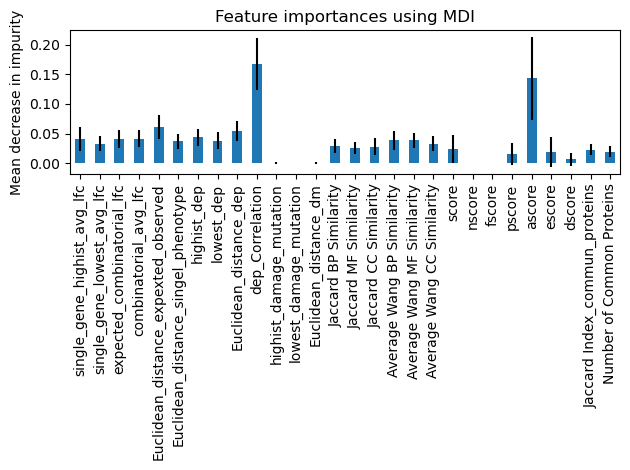

Elapsed time to compute the importances (permutation with accuracy): 3.947 seconds


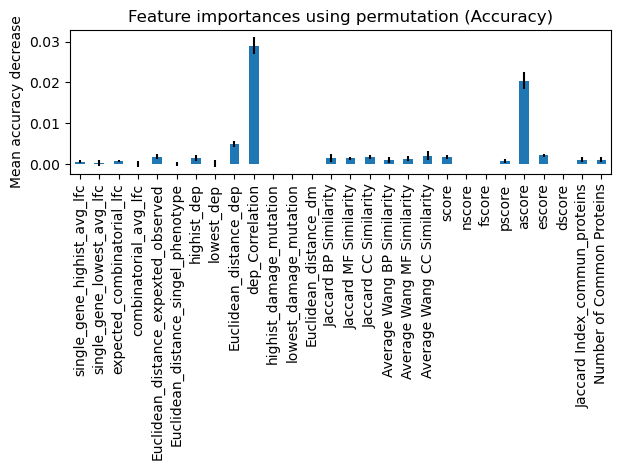

Elapsed time to compute the importances (permutation with F1 score): 3.087 seconds


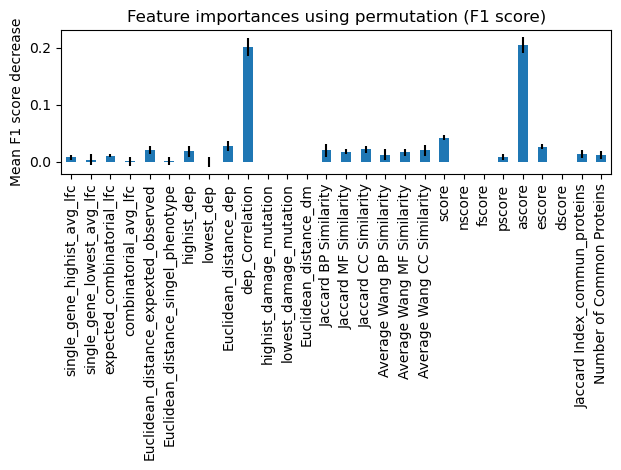

Feature importances (MDI):
single_gene_highist_avg_lfc             0.040614
single_gene_lowest_avg_lfc              0.033140
expected_combinatorial_lfc              0.040425
combinatorial_avg_lfc                   0.041642
Euclidean_distance_expexted_observed    0.060512
Euclidean_distance_singel_phenotype     0.036824
highist_dep                             0.043859
lowest_dep                              0.037560
Euclidean_distance_dep                  0.054381
dep_Correlation                         0.167491
highist_damage_mutation                 0.000395
lowest_damage_mutation                  0.000000
Euclidean_distance_dm                   0.000438
Jaccard BP Similarity                   0.028513
Jaccard MF Similarity                   0.025927
Jaccard CC Similarity                   0.028012
Average Wang BP Similarity              0.038817
Average Wang MF Similarity              0.038619
Average Wang CC Similarity              0.032992
score                                   0.

In [99]:
# Call the function 
forest_importances, forest_importances_perm, forest_importances_perm_f1 = feature_importance_analysis(X_train, y_train, X_test, y_test)

# Now you can inspect the DataFrames:
print("Feature importances (MDI):")
print(forest_importances)
print("Feature importances (Permutation - Accuracy):")
print(forest_importances_perm)
print("Feature importances (Permutation - F1 score):")
print(forest_importances_perm_f1)

# Extract the data 

In [100]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import pandas as pd

def random_forest_extract(X_train, y_train, X_test, y_test, positive_class=1):
    """
    Train and evaluate a Random Forest classifier, and extract predictions for a specified class.
    
    Parameters:
    - X_train: Training features (DataFrame or array).
    - y_train: Training labels (Series or array).
    - X_test: Test features (DataFrame or array).
    - y_test: Test labels (Series or array).
    - positive_class: The class for which predictions are extracted (default is 1).

    Returns:
    - results_df: DataFrame containing True labels, Predicted labels, and class probabilities.
    - class_predictions: DataFrame containing samples predicted as the specified positive class.
    - classification_report_dict: Dictionary containing classification metrics.
    """
    # Step 1: Train the Random Forest model
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    # Step 2: Get predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)

    # Step 3: Create a DataFrame to hold predictions and probabilities
    results_df = pd.DataFrame(X_test, columns=X_train.columns)  # Use original column names if available
    results_df['True_Label'] = y_test
    results_df['Predicted_Label'] = y_pred
    results_df[f'Probability_Class_{positive_class}'] = y_proba[:, positive_class]

    # Step 4: Filter for samples predicted as the positive class
    class_predictions = results_df[results_df['Predicted_Label'] == positive_class]

    # Step 5: Classification Report
    classification_report_dict = classification_report(y_test, y_pred, output_dict=True)

    # Print the classification report for overall performance
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Return the full results, class predictions for the positive class, and metrics
    return results_df, class_predictions, classification_report_dict



In [101]:
# Run the workflow
results_df, class_1_predictions, metrics = random_forest_extract(X_train, y_train, X_test, y_test, positive_class=1)

# Display the full results (including predicted probabilities)
print("\nFull Results (Predictions, True Labels, and Probabilities):")
print(results_df.head())  # Print first 5 rows

# Display samples predicted as class 1
print("\nSamples Predicted as Class 1:")
print(class_1_predictions)

# Display classification metrics
print("\nMetrics (Classification Report):")
print(metrics)


Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1138
           1       0.92      0.47      0.62        93

    accuracy                           0.96      1231
   macro avg       0.94      0.73      0.80      1231
weighted avg       0.96      0.96      0.95      1231


Full Results (Predictions, True Labels, and Probabilities):
      single_gene_highist_avg_lfc  single_gene_lowest_avg_lfc  \
7548                     0.561710                   -0.179218   
8325                     0.087559                   -0.149699   
1632                    -1.193559                   -2.118876   
6255                     0.135692                   -0.638373   
1573                    -0.100981                   -1.357408   

      expected_combinatorial_lfc  combinatorial_avg_lfc  \
7548                    0.382492               0.091053   
8325                   -0.062140              -0.450525   
1632                 

In [102]:
class_1_predictions

,single_gene_highist_avg_lfc,single_gene_lowest_avg_lfc,expected_combinatorial_lfc,combinatorial_avg_lfc,Euclidean_distance_expexted_observed,Euclidean_distance_singel_phenotype,highist_dep,lowest_dep,Euclidean_distance_dep,dep_Correlation,...,fscore,pscore,ascore,escore,dscore,Jaccard Index_commun_proteins,Number of Common Proteins,True_Label,Predicted_Label,Probability_Class_1
5548,0.506189,-0.701134,-0.194946,-0.264051,0.069105,1.207323,-0.231784,-0.543999,0.312215,0.183561,...,0.0,0.050,0.768,0.703,0.000,0.052632,1,1,1,0.69
4810,-2.017250,-3.560934,-5.578184,-2.316298,3.261886,1.543684,-1.510193,-1.598131,0.087938,0.036154,...,0.0,0.079,0.917,0.997,0.967,0.818182,9,1,1,0.82
8139,0.533049,0.195854,0.728903,-0.033012,0.761914,0.337195,0.156403,0.005474,0.150928,0.209033,...,0.0,0.000,0.000,0.000,0.000,0.058824,1,1,1,0.86
5209,0.379527,-0.333130,0.046397,-0.286613,0.333010,0.712657,-0.025609,-0.033131,0.007522,0.219080,...,0.0,0.000,0.000,0.000,0.000,0.333333,5,1,1,0.85
8191,0.580353,0.534564,1.114917,0.066469,1.048448,0.045788,-0.003204,-0.052133,0.048929,0.336002,...,0.0,0.049,0.465,0.237,0.000,0.125000,2,1,1,0.87
2159,-1.562377,-3.055147,-4.617524,-2.098655,2.518868,1.492769,-1.571146,-1.664918,0.093772,0.366345,...,0.0,0.000,0.595,0.997,0.900,0.818182,9,1,1,0.98
5250,-1.528820,-2.556705,-4.085525,-1.914705,2.170820,1.027885,-0.039580,-0.158893,0.119314,0.712322,...,0.0,0.000,0.067,0.957,0.900,0.250000,4,1,1,0.81
6676,0.785371,-1.320579,-0.535208,-0.364961,0.170246,2.105950,-0.128452,-1.352921,1.224469,-0.148778,...,0.0,0.000,0.368,0.533,0.900,0.666667,8,1,1,0.57
799,0.401086,-0.672085,-0.270999,-0.950479,0.679480,1.073171,0.131771,-0.097666,0.229437,0.052561,...,0.0,0.000,0.366,0.163,0.000,0.000000,0,1,1,0.67
1860,-0.280074,-0.923895,-1.203969,-0.701240,0.502729,0.643821,-0.015053,-0.035862,0.020810,0.093211,...,0.0,0.059,0.416,0.422,0.900,0.250000,4,1,1,0.54


In [103]:
# Merge the DataFrames based on common columns
common_columns = ['single_gene_highist_avg_lfc', 'single_gene_lowest_avg_lfc', 'expected_combinatorial_lfc',
                  'combinatorial_avg_lfc', 'Euclidean_distance_expexted_observed', 'Euclidean_distance_singel_phenotype',
                   'highist_dep',
                  'fscore', 'pscore', 'ascore', 'escore', 'dscore', 'Jaccard Index_commun_proteins', 
                  'Number of Common Proteins']

merged_df_positives = class_1_predictions.merge(
    filtered_df[['Class_label_sum','Class_label_exp', 'Class_label_dep','Class_label_corr','cell_line', 'condition', 'Gene_combination'] + common_columns],
    on=common_columns, how='left'
)

In [104]:
merged_df_positives

,single_gene_highist_avg_lfc,single_gene_lowest_avg_lfc,expected_combinatorial_lfc,combinatorial_avg_lfc,Euclidean_distance_expexted_observed,Euclidean_distance_singel_phenotype,highist_dep,lowest_dep,Euclidean_distance_dep,dep_Correlation,...,True_Label,Predicted_Label,Probability_Class_1,Class_label_sum,Class_label_exp,Class_label_dep,Class_label_corr,cell_line,condition,Gene_combination
0,0.506189,-0.701134,-0.194946,-0.264051,0.069105,1.207323,-0.231784,-0.543999,0.312215,0.183561,...,1,1,0.69,no GI,GI,no GI,GI,Meljuso,2CP sel,HNRNPR_SYNCRIP
1,-2.017250,-3.560934,-5.578184,-2.316298,3.261886,1.543684,-1.510193,-1.598131,0.087938,0.036154,...,1,1,0.82,GI,no GI,no GI,GI,Meljuso,2CP sel,CCT3_CCT7
2,0.533049,0.195854,0.728903,-0.033012,0.761914,0.337195,0.156403,0.005474,0.150928,0.209033,...,1,1,0.86,no GI,no GI,GI,GI,Meljuso,2CP sel,ZNF304_ZNF548
3,0.379527,-0.333130,0.046397,-0.286613,0.333010,0.712657,-0.025609,-0.033131,0.007522,0.219080,...,1,1,0.85,no GI,no GI,GI,GI,Meljuso,2CP sel,EOLA1_EOLA2
4,0.580353,0.534564,1.114917,0.066469,1.048448,0.045788,-0.003204,-0.052133,0.048929,0.336002,...,1,1,0.87,GI,GI,GI,GI,Meljuso,2CP sel,ZNF324_ZNF324B
5,-1.562377,-3.055147,-4.617524,-2.098655,2.518868,1.492769,-1.571146,-1.664918,0.093772,0.366345,...,1,1,0.98,GI,no GI,GI,GI,A375,2CP,RFC2_RFC5
6,-1.528820,-2.556705,-4.085525,-1.914705,2.170820,1.027885,-0.039580,-0.158893,0.119314,0.712322,...,1,1,0.81,GI,GI,GI,GI,Meljuso,2CP sel,EXT1_EXT2
7,0.785371,-1.320579,-0.535208,-0.364961,0.170246,2.105950,-0.128452,-1.352921,1.224469,-0.148778,...,1,1,0.57,no GI,no GI,no GI,GI,Meljuso,2CP sel,SETD1A_SETD1B
8,0.401086,-0.672085,-0.270999,-0.950479,0.679480,1.073171,0.131771,-0.097666,0.229437,0.052561,...,1,1,0.67,no GI,GI,no GI,GI,A375,2CP,EHF_ELF3
9,-0.280074,-0.923895,-1.203969,-0.701240,0.502729,0.643821,-0.015053,-0.035862,0.020810,0.093211,...,1,1,0.54,no GI,no GI,no GI,GI,A375,2CP,PLOD1_PLOD3


In [105]:
merged_df_positives.to_csv('GI_prediction_RNA exprestion_label.csv', index=False)